## Coursera - IBM Data Science Capstone Project ##

### Brian Lee ###
BrianTrewLee@gmail.com<br />
LinkedIn: https://www.linkedin.com/in/brian-lee-data




## 1. Introduction ##

If I were to open a Starbucks, where should I locate it? Clearly, the location is one of the most important business decisions for this venture. Is there a science to locating a StarBucks? Can we create a machine learning model to predict where a StarBucks is likely to be located? I'd like to find out.

If a reliable model can be made, it could be used in the process of opening a store. It could be used as a final sanity check, or at the beginning stage, to select a promising location. If a trustworthy model predicts with a high degree of confidence that a Starbucks should be located in an area, but there is not one there yet, perhaps that is an opportunity.

Any person interested in opening a Starbucks should be interested in these results. This includes myself, other potential franchisees, and the Starbucks corporation itself, which operates many of it's own stores. The Starbucks competition might also be interested as they could possibly gain competitive insigths. I also believe others might be interested in this procedure, as it might be applied to predicting the location of other entities, based on the same sort of data.

The main purpose of this project is to prove the concept of predicting Starbuck's locations in general. I suspect it may work better or worse depending on the locations chosen for training and prediction, the radius size, and the specific features used in the model. I may vary those factors in order to prove the concept, which could then be applied carefully to a particular geographic area of interest at a later date.

### 2. Data ###

Foursquare (https://foursquare.com) is a company that crowdsources location data, tying latitude-longitude coordinates (and other things) with public venues, including many businesses, such as Starbucks locations. The features for the Starbucks location classifier will come from venue data from the Fourquare API. I will use venue category names (such as 'bar', 'Chinese restaurant', 'coffee shop') as features to classify an area as either an area with a Starbucks, or an area without one. I will use the venue name (e.g. 'Starbucks') to determine whether or not the venue is a Starbucks. An area containing a Starbucks contains at least one venue named 'Starbucks' within the radius supplied to the Foursquare API's explore' endpoint.

An area will be a circular area with a given radius. I have not determined that radius yet, and I might use more than one radius in this project. Within that radius, the Foursquare API will return venues. The larger the radius, the more venues that could be anticipated, and the higher likelihood of a Starbucks, but a larger radius is also less useful for business use. I have done some exploratory work with a radius of 300m.

The areas to be chosen should contain a mix of areas with Starbuck's and those without. I have done some exploratory work in a particular area of San Francisco. I located Starbucks with Google Maps and got latitude and longitude points making a box around that area. I could choose the train and test points at random within an area, or I could generate a grid covering an entire area. Given the constraints my Foursquare Developer account places on my searches, and knowing that binary classifiers work better with a good number of examples of both classes, I may want to generate areas that I know will be heavy with Starbucks locations. To that end, I discovered a Kaggle dataset (https://www.kaggle.com/starbucks/store-locations) containing the latitude and longitude coordinates of 25,600 worldwide Starbucks locations. I may or may not use that resource.

### 3. Methodology ###

I will generate a corpus of geographic points, and using a reasonable radius (perhaps 300m) a corpus of geographic areas. Each geographic area will have a feature set based on json data returned by the Foursquare API's 'explore' endpoint. I plan to use the category names of the returned venues as features for that area. I will use the venue names to determine whether oir not a Starbucks is in that area, and generate the labels from that. 

Once I have labelled data, I will use sklearn.model_selection.train_test_split to generate tarining and testing sets. Then I  can use any of a host of sklearn classifiers to generate predictive models. I have done some exploratory work with a random forest.

In [1]:
# @hidden_cell
CLIENT_ID='0C4GFTHUCEID10D2EF5OUUVTPDE3LRKIKOCWYOXSVTN0L3FB'
CLIENT_SECRET='UC52VVB1WLAD40QJIBUYHX54AMWFXPGJEMM4C0OZRGCOHWFZ'
VERSION='20180608'
LIMIT = 100

In [2]:
# import libraries

import urllib.request # open and read URLs

import json # handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # handle requests
import pandas as pd # process data as dataframes with Pandas
import numpy as np # handle data in a vectorized manner with NumPy

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed the GeoPy geocoding library yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

##!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed the Folium library yet
import folium # map rendering library

# Matplolib plotting library and associated modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

import random
import geopy
from geopy.distance import VincentyDistance
from sklearn.model_selection import train_test_split
import sklearn as sk  
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.cluster import KMeans # for K-Means clustering with Scikit-Learn

print("Libraries imported!")

Libraries imported!


In [3]:
# set global parameters
eliminate_starbucks_venue_rows = True # It seems like we should eliminate actual Starbucks locations from our training data
#MAX_DEPTH=8
MAX_DEPTH=12 # better but signs of overfitting
MAX_DEPTH=5 # had an excellent run but possible underfitting
#MAX_DEPTH=4
MAX_DEPTH=6
get_new_data = False
#venue_saved_data_file_name = 'venues_saved_data_big'
venue_saved_data_file_name = 'venues_saved_data_small'
verbose = True
quick = False
slow_maps = True

In [4]:
class SVM:
    def __init__(self, name, kernel_type, X_train, y_train, X_test, y_test, X_val, y_val):
        self.ClassifierType = "Support Vector Machine"
        self.name = name 
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val        
        self.kernel_type = kernel_type
        self.svm_model = svm.SVC(kernel=kernel_type, C=1, gamma=1, probability=True) 
        print(self.ClassifierType + " - " + name + " created")
    def fit(self):
        fit = self.svm_model.fit(X_train, y_train)
    def predict(self, X):
        predicted = self.svm_model.predict(X)
    def score(self, X, y):
        score = self.svm_model.score(X, y)
    def get_num_features(self):
        return(len(X_train.columns))       
    def print_scores(self):
        self.svm_model.score(X_train,y_train)
        self.test_accuracy = self.svm_model.score(X_test,y_test)
        self.validation_accuracy = self.svm_model.score(X_val,y_val)
        
        print("-----" + self.name + "-----")        
        svm_prob_y_train = self.svm_model.predict_proba(X_train)
        svm_prob_y_test = self.svm_model.predict_proba(X_test)      
        svm_prob_y_val = self.svm_model.predict_proba(X_val)         
        
        self.average_of_test_and_validation_accuracy = (self.test_accuracy + self.validation_accuracy)/2
        self.test_aucroc = roc_auc_score(y_test, svm_prob_y_test[:,1])
        self.validation_aucroc = roc_auc_score(y_val, svm_prob_y_val[:,1])   
        self.average_of_test_and_validation_aucroc = (self.test_aucroc + self.validation_aucroc)/2
        
        
        

        print(self.name + " Train accuracy = " + str(self.svm_model.score(X_train,y_train)))        
        print(self.name + " Train ROC AUC = " + str(roc_auc_score(y_train, svm_prob_y_train[:,1])))
        print(self.name + " Test accuracy = " + str(self.svm_model.score(X_test,y_test)))
        print(self.name + " Test ROC AUC = " + str(roc_auc_score(y_test, svm_prob_y_test[:,1]))) 
        print(self.name + " Validation accuracy = " + str(self.svm_model.score(X_val,y_val))) 
        print(self.name + " Validation ROC AUC = " + str(roc_auc_score(y_val, svm_prob_y_val[:,1])))   
        print("\n" + self.name + " Average of Test and Validation accuracy: " + str(self.average_of_test_and_validation_accuracy))  
        print(self.name + " Average of Test and Validation ROC AUC score: " + str(self.average_of_test_and_validation_aucroc))  
   
        print("\n\n" + str(len(X_train.columns)))

In [5]:
class RF:
    #rfc = RandomForestClassifier(n_estimators=100, max_depth=MAX_DEPTH, random_state=0)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=MAX_DEPTH, random_state=0)
    def __init__(self, name, X_train, y_train, X_test, y_test, X_val, y_val):
        self.ClassifierType = "Random Forest"
        self.name = name 
        self.X_train = X_train
        self.y_train = y_train
        self.y_train = X_test
        self.y_train = y_test
        self.y_train = X_val
        self.y_train = y_val
        
        self.rfc = RandomForestClassifier(n_estimators=100, max_depth=MAX_DEPTH, random_state=0)
        print(self.ClassifierType + " - " + name + " created")
        
    #def visualize_first_estimator(self):
        
    def get_estimator(self, estimator_num):        
        estimator =  self.f.estimators_[estimator_num]
        return(estimator)
        
    def fit(self):
        self.f = self.rfc.fit(X_train,y_train)
    def predict(self, X):
        self.predictions = RF.rfc.predict(X)   
        #print(self.predictions)
    def predict_all(self, X):
        self.test_predictions = RF.rfc.predict(X_test)   
        self.val_predictions = RF.rfc.predict(X_val)           
        #print(self.predictions)              
        
    def get_and_print_results(self):
        self.prob_y_train = self.rfc.predict_proba(X_train)
        self.prob_y_test = self.rfc.predict_proba(X_test)
        if len(X_val) > 0 and len(y_val) > 0 :
            self.prob_y_val = self.rfc.predict_proba(X_val)
        
        self.num_features = self.f.n_features_
        print(self.num_features)        
        self.train_accuracy = self.rfc.score(X_train,y_train)
        self.test_accuracy = self.rfc.score(X_test,y_test)
        if len(X_val) > 0 and len(y_val) > 0 :
            self.validation_accuracy = self.rfc.score(X_val,y_val)        
        
        self.feature_importances = self.rfc.feature_importances_
        print("-----"+self.name+"-----")
        print(self.name + " Train accuracy = " + str(self.train_accuracy))  
        print(self.name + " Train ROC AUC = " + str(roc_auc_score(y_train, self.prob_y_train[:,1])))
        print(self.name + " Test accuracy = " + str(self.test_accuracy))  
        print(self.name + " Test ROC AUC = " + str(roc_auc_score(y_test, self.prob_y_test[:,1])))
    
        self.validation_accuracy = roc_auc_score(y_val, self.prob_y_val[:,1])
        self.average_test_and_validation_accuracy = (self.validation_accuracy + self.test_accuracy)/2
        self.test_rocauc = roc_auc_score(y_test, self.prob_y_test[:,1])
        self.validation_rocauc = roc_auc_score(y_val, self.prob_y_val[:,1])
        self.average_test_and_validation_rocauc = (self.test_rocauc + self.validation_rocauc)/2
        
        print(self.name + " Validation accuracy = " + str(self.validation_accuracy))  
        print(self.name + " Validation ROC AUC = " + str(roc_auc_score(y_val, self.prob_y_val[:,1])))

        print("\n" + self.name + " Average of Test and Validation accuracy: " + str(self.average_test_and_validation_accuracy))  
        print(self.name + " Average of Test and Validation ROC AUC score: " + str(self.average_test_and_validation_rocauc))  

        print(self.name + " Num Features: " + str(self.num_features)) 
        
        self.feature_importance_info = []
        for i in range(0,self.num_features):
            if self.feature_importances[i] >= 0:
                self.feature_importance_info.append((self.feature_importances[i],X_train.columns[i]))
    
        self.feature_importance_df = pd.DataFrame(self.feature_importance_info)
        self.feature_importance_df.rename(columns={0: "Feature Importance", 1: "Feature"}, inplace=True)
        self.feature_importance_df.sort_values(by="Feature Importance",ascending=False,inplace=True)    
        
        self.feature_importance_df.set_index('Feature',inplace=True)
        self.feature_importance_df       

        
print("refreshed")        

refreshed


In [6]:
# Define a function to gather recommended venues, with specifically the name and category, using the explore API
def getNearbyVenues(latitudes, longitudes, radius=300, limit=100):
    
    count = 0
    venues_list = []
    test_list = []
    for lat, lng in zip(latitudes, longitudes):
        #create a unique name for this point that is easier to deal with than a combination of lat and lon
        point_name = "point"+str(count).zfill(5)
        if verbose:
            print(point_name,':',lat,'-',lng)
         
        else:
            # progress indicator for the impatient among us
            if(count%1 == 0):
                #print('.', end='', flush=True)
                print("\r{0}".format(round((float(count)/len(latitudes))*100,1))+"% done", end='')
            
        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]["groups"][0]["items"]
        except:
            try:
                results = requests.get(url).json()["response"]["groups"][0]["items"]
            except:
                print("\nfailed to get results")
                
        # return only relevant information for each nearby venue
        venues_list.append([(
            point_name,
            lat, 
            lng,  
            #v["venue"]["name"], 
            v["venue"]["name"].lower().capitalize(),            
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["location"]["distance"], 
            v["venue"]["categories"][0]["name"]) for v in results])        

  

        if (len(results)<1):
            venues_list.append([(
                point_name,
                lat, 
                lng, 
                "", 
                0, 
                0,  
                0, 
                "no venue")])
                
                
        test_list.append([(point_name) for v in results])
        
    
        count = count + 1
    print("\r100% done", end='') 
    #print("\r{0}".format(round((float(count)/len(latitudes))*100,1))+"% done", end='')
         
    print("\n\n")    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    print("nearby_venues length:" + str(len(nearby_venues)))      
    
    nearby_venues.columns = ["Point Name",
                  "Neighborhood Latitude", 
                  "Neighborhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Distance",           
                  "Venue Category"]
    print("# of unique points in nearby_venues ="+str(len(nearby_venues["Point Name"].unique())))
    return(nearby_venues)

In [7]:
# It is possible that Foursqaure may have incorrect data
# I have seen areas with venues where the API returned no results
def getStarbucksLocations(lat, lng, limit=200):
    
    count = 0
    starbucks_list = []
    #for lat, lng in zip(latitudes, longitudes):
        #create a unique name for this point that is easier to deal with than a combination of lat and lon
    this_radius = 300
         
    
            
        # create the API request URL
       # url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        #url = "https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}".format(
    #url = "https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&ne={},{}&sw={},{}&query={}".format(
    url = "https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&limit={}&radius={}&ll={},{}&query={}".format(
          
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            limit,
            this_radius,
            lat,
            lng,
            "Starbucks")
    sb_coords = []
    # make the GET request
   # results = requests.get(url).json()["response"]["venues"]["location"]
    try:
        results = requests.get(url).json()["response"]["venues"]
    except:
        try:
            results = requests.get(url).json()["response"]["venues"]
        except:
            results = []
    
    for result in results:
        sb_coords.append((result["location"]["lat"],result["location"]["lng"]))
        
    if (len(results)<1):
        if verbose ==True:
            print("no starbucks location results")
    return(sb_coords)


In [8]:
sf_lat=37.7749
sf_lon=-122.4194

In [9]:
llat=37.7
#double the area by heading south
llat=37.6
ulat = 37.807957
llon = -122.494329
ulon = -122.395276

points = []
val_points = []
radius = 300 #in meters
current_lat = ulat
current_lon = llon

d = radius/1000 #in kilometers
d=d*2
b=90 #in degrees 90 = east,180=south,270=west
# given: lat1, lon1, b = bearing in degrees, d = distance in kilometers      
 
def lon_pass(current_lat, current_lon, ulat, ulon, pnts):
    while (current_lat <= ulat) and (current_lon <= ulon) and (current_lat >= llat):    
        origin = geopy.Point(current_lat, current_lon)
        destination = VincentyDistance(kilometers=d).destination(origin, b)
        current_lat, current_lon = destination.latitude, destination.longitude
        if verbose==True:
            print(current_lat, current_lon)
        pnts.append(list((current_lat, current_lon)))
    return(pnts)
        
 
        

def generate_points(llat, llon, ulat, ulon):
    pnts=[]
    current_lat = ulat
    current_lon = llon   
    #while (current_lat <= ulat) and (current_lon <= ulon) and (current_lat >= llat) and (current_lon >= llon):
    while (current_lat <= ulat) and (current_lon <= ulon) and (current_lat >= llat):
        pnts = lon_pass(current_lat, current_lon, ulat, ulon, pnts)
        print('new row of coordinates')  
        current_lon=llon#move back to beginning of row   
        origin = geopy.Point(current_lat, current_lon)
        destination = VincentyDistance(kilometers=d).destination(origin, 180)#move south one step for next row
        current_lat, current_lon = destination.latitude, destination.longitude       
    return(pnts)

In [10]:
points = generate_points(llat, llon, ulat, ulon)


37.80795680296507 -122.48751554492938
37.807956605930144 -122.48070208987684
37.807956408895215 -122.47388863484242
37.80795621186029 -122.4670751798261
37.807956014825365 -122.46026172482789
37.80795581779044 -122.45344826984777
37.80795562075552 -122.44663481488575
37.80795542372061 -122.43982135994185
37.80795522668569 -122.43300790501604
37.80795502965077 -122.42619445010834
37.80795483261586 -122.41938099521875
37.80795463558094 -122.41256754034725
37.807954438546034 -122.40575408549387
37.807954241511126 -122.39894063065857
37.80795404447622 -122.3921271758414
new row of coordinates
37.80255104525841 -122.48751604155096
37.80255084826162 -122.48070308312
37.80255065126483 -122.47389012470715
37.80255045426805 -122.46707716631241
37.802550257271264 -122.46026420793575
37.802550060274484 -122.45345124957718
37.802549863277704 -122.44663829123671
37.80254966628091 -122.43982533291432
37.80254946928414 -122.43301237461004
37.80254927228736 -122.42619941632387
37.802549075290585 -122.

#### We many need more examples of the near-Starbucks class for a balanced set - so get a bunch of points we know are near to Starbucks
I pulled coordinates from the Kaggle Starbucks locations dataset<br />
The precision of the Kaggle set wasn't good enough to ensure the Starbucks location would be within the radius chosen, so I found a different dataset with higher precision

In [11]:
#starbucks_heavy_coordinates = pd.read_csv('data/directory-us-ca.csv') #this file gave lat-lon tothe hundreths, but that isn't good enough to ensure a Starbucks is within my radius
starbucks_heavy_coordinates = pd.read_csv('data/starbucks_us_ca_locations.csv',header=None)
starbucks_heavy_coordinates.columns = ["Longitude", "Latitude", "Location", "Address"]
# These coordinates aren't always precise enough to trigger a Starbucks location in the Foursquare API within the required radius
# For that reason, pulling an equal number of coordinate points from this set doesn't necessarily balance the classes exactly
# Sometimes two different coordinate points in this set are given for a single Starbucks location. They are rare enough to be ignored for now.

In [12]:
starbucks_heavy_coordinates.head()

Longitude   Latitude                               Location  \
0 -118.114954  34.079000   Starbucks - CA - ALHAMBRA [W]  00373   
1 -117.428300  34.626700  Starbucks - CA - Adelanto [WD]  00374   
2 -118.757319  34.153435   Starbucks - CA - Agoura Hills  00375   
3 -118.757134  34.160600     Starbucks - CA - Agoura [W]  00376   
4 -122.277604  37.788222        Starbucks - CA - Alameda  00377   

                                             Address  
0  Valley & Almansor, Alhambra_810 E VALLEY BLVD_...  
1  Palmdale & Hwy 395, Adelanto_14136 US Hwy 395_...  
2  Vons-Agoura Hills #2001_5671 Kanan Rd._Agoura ...  
3  Agoura_5827 Canan Road_Agoura, California 9130...  
4  Albertsons-Alameda #7031_815 Marina Village_Al...

In [13]:
#num_needed_to_balance = len(points) #This does a good enough job of balancing the classes
num_needed_to_balance = int(len(points)*2) #This balances the classes better
num_needed_to_balance

1170

In [14]:
shc_lat, shc_lon = starbucks_heavy_coordinates.Latitude, starbucks_heavy_coordinates.Longitude

nnl=(shc_lat[0:num_needed_to_balance],shc_lon[0:num_needed_to_balance])
pnnl = pd.DataFrame(nnl)
pnnl.shape
pnnl = pnnl.transpose()
pnnl
newlats=pnnl['Latitude']
newlons=pnnl['Longitude']
newlats
points = pd.DataFrame(points)
current_end = len(points)

#exclude class balancing coordinates from being generated in the original area
#negative longitudes make the logic a litle funny below
exclusion_llat = llat*.9995
exclusion_llon = llon*1.001
exclusion_ulat = ulat*1.001
exclusion_ulon = ulon*.99

#print("exclusion_llat=" + str(exclusion_llat) )
#print("exclusion_llon=" + str(exclusion_llon) )
#print("exclusion_ulat=" + str(exclusion_ulat) )
#print("exclusion_ulon=" + str(exclusion_ulon) )


for i in range(0,num_needed_to_balance):
    #add a condition to prevent these points from being inside my original area
    if newlats[i] < exclusion_llat or newlats[i] > exclusion_ulat or newlons[i] > exclusion_llon or newlons[i] < exclusion_ulon:
        #print(newlats[i],newlons[i])
        #print((newlats[i] < exclusion_llat))     
        #print((newlats[i] > exclusion_ulat))
        #print((newlons[i] < exclusion_llon))
        #print((newlons[i] > exclusion_ulon))
        lenp = len(points)
        points = points.set_value(lenp, 0, newlats[i])
        points = points.set_value(lenp, 1, newlons[i])  

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [15]:
points.shape

(1755, 2)

shuffle the points

In [16]:
points = points.sample(frac=1).reset_index(drop=True)

In [17]:
points.tail()

0           1
1750  34.052178 -118.255395
1751  37.737681 -122.453487
1752  34.085446 -117.670099
1753  37.427722 -122.149109
1754  37.807957 -122.480702

In [18]:
map_training_data = folium.Map(location=[ulat, ulon], zoom_start=11)


# add markers to map
for lat, lng in zip(points[0],points[1]):
    
    if (lat <= ulat) and (lng*1.00005 <= ulon) and (lat > llat*1.00005) and (lng >=llon):#had to multiply by a tad to avoid rounding errors
    #if (lat <= exclusion_ulat) and (lng <= exclusion_llon) and (lat >= exclusion_llat) and (lng >=exclusion_ulon):#had to multiply by a tad to avoid rounding errors
      
    #if (lat <= exclusion_ulat) and (lat >= exclusion_llat and (lng >= exclusion_llon) and (lng <=exclusion_ulon)):#had to multiply by a tad to avoid rounding errors
      
        
        marker_color = 'navy'
    else:
        marker_color = 'brown'
        
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=marker_color,
        #fill=True,
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_training_data)  
    

In [19]:

map_training_data_legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 44px; width: 148px; height: 130px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            #background: white;
                            ">
                              <div style="font-size:10px;"><br />&nbsp; Training classes balanced<br /> 
                              &nbsp; with known Starbucks<br />
                              &nbsp; locations throughout<br />
                              &nbsp; California<br />  
                              </div>
                              
                              &nbsp;&nbsp;&nbsp; unknown: &nbsp; <i class="fa fa-circle-o style="color:navy"></i><br>
                              &nbsp;&nbsp;&nbsp; known: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <i class="fa fa-circle-o" style="color:brown">
                              </i>
                </div>
                ''' 
map_training_data.get_root().html.add_child(folium.Element(map_training_data_legend_html))

In [20]:
map_training_data

In [21]:
get_new_data = False

In [22]:
if get_new_data == True:
    venues = getNearbyVenues(latitudes = points[0],
                              longitudes =  points[1]
                               )
    # save venues as a csv file so I can rerun without having to use up my Foursquare API limits
    venues.to_csv(venue_saved_data_file_name, encoding='utf-8', index=False)
else:
    venues = pd.read_csv(venue_saved_data_file_name) 

In [23]:
#get_new_data = True

In [24]:
venues.tail()

Point Name  Neighborhood Latitude  Neighborhood Longitude  \
17892  point00899               37.92886             -122.320997   
17893  point00899               37.92886             -122.320997   
17894  point00899               37.92886             -122.320997   
17895  point00899               37.92886             -122.320997   
17896  point00899               37.92886             -122.320997   

                                       Venue  Venue Latitude  Venue Longitude  \
17892  Launderland coin laundry - el cerrito       37.927403      -122.320287   
17893              Kelly's deli @ home depot       37.929377      -122.322657   
17894               Banana leaf thai cuisine       37.929271      -122.321077   
17895                          Brasil bistro       37.929366      -122.320795   
17896                             Mcdonald's       37.928097      -122.321057   

       Venue Distance        Venue Category  
17892             173            Laundromat  
17893             156         Deli / Bodega  
17894              46       Thai Restaurant  
17895              59            Restaurant  
17896              85  Fast Food Restaurant

In [25]:
venues['Venue Category'].value_counts()

Coffee Shop                                 872
Pizza Place                                 584
Sandwich Place                              558
Mexican Restaurant                          557
Fast Food Restaurant                        533
Chinese Restaurant                          446
Grocery Store                               410
Clothing Store                              355
American Restaurant                         302
Pharmacy                                    287
Sushi Restaurant                            274
Ice Cream Shop                              272
Bakery                                      268
Bank                                        267
Café                                        266
Burger Joint                                250
Italian Restaurant                          249
Cosmetics Shop                              246
Hotel                                       217
Mobile Phone Shop                           201
Japanese Restaurant                     

In [26]:
# fill in blank venues
i = 0 
for vv in venues['Venue']:
    if len(str(venues['Venue'][i])) < 1:
        venues['Venue'][i] = 'no venue'
    i = i + 1  
#validation_venues['Venue'].value_counts() 

In [27]:
venues['Venue'].unique()
venues['Venue'].value_counts()

Starbucks                                            521
Subway                                               264
Chase bank                                           145
The ups store                                        107
Mcdonald's                                           100
Cvs pharmacy                                         100
Panda express                                         99
Jamba juice                                           92
Redbox                                                91
Taco bell                                             85
Walgreens                                             79
Baskin-robbins                                        77
Shell                                                 76
Gamestop                                              76
Chipotle mexican grill                                72
Rite aid                                              71
Jack in the box                                       67
Wells fargo                    

In [28]:
venues['Venue Category'].unique()

array(['Taco Place', 'Seafood Restaurant', 'Candy Store',
       'Italian Restaurant', 'Juice Bar', 'Pizza Place', 'Breakfast Spot',
       'Wings Joint', 'Coffee Shop', 'Deli / Bodega',
       'American Restaurant', 'Burger Joint', 'Department Store',
       'Mexican Restaurant', 'Sandwich Place', 'Comic Shop', 'Shoe Store',
       'Arcade', 'Accessories Store', 'Steakhouse', 'Salon / Barbershop',
       'BBQ Joint', 'Clothing Store', 'Mobile Phone Shop', 'Pharmacy',
       'Hot Dog Joint', 'Fast Food Restaurant', 'Asian Restaurant',
       'Chinese Restaurant', 'Furniture / Home Store', 'Flower Shop',
       'Latin American Restaurant', 'Southern / Soul Food Restaurant',
       'Grocery Store', 'Light Rail Station', 'Fried Chicken Joint',
       'Auto Garage', 'Bakery', 'Bus Station', 'Market', 'Ice Cream Shop',
       'Mediterranean Restaurant', 'Smoke Shop', 'Sushi Restaurant',
       'Cosmetics Shop', 'Kitchen Supply Store', 'Shopping Plaza',
       'Sporting Goods Shop', 'Bank', 

In [29]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['point_name'] = venues['Point Name'] 
onehot['point_lat'] = venues['Neighborhood Latitude'] 
onehot['point_lon'] = venues['Neighborhood Longitude'] 
onehot['isStarbucks'] = (venues['Venue'] == "Starbucks")
# move neighborhood column to the first column
fixed_columns = [onehot.columns[-3]] + [onehot.columns[-2]] + [onehot.columns[-1]] + list(onehot.columns[:-3])
onehot = onehot[fixed_columns]

onehot.isStarbucks = onehot.isStarbucks.astype(int)

onehot.head()
onehot['isStarbucks'].value_counts()

0    17376
1      521
Name: isStarbucks, dtype: int64

In [30]:
venues.head()

Point Name  Neighborhood Latitude  Neighborhood Longitude  \
0  point00000              32.629036             -117.088786   
1  point00000              32.629036             -117.088786   
2  point00000              32.629036             -117.088786   
3  point00000              32.629036             -117.088786   
4  point00000              32.629036             -117.088786   

                   Venue  Venue Latitude  Venue Longitude  Venue Distance  \
0         Tacos el gordo       32.629079      -117.089024              22   
1  Rubio's coastal grill       32.630335      -117.087613             181   
2          See's candies       32.630213      -117.087919             154   
3           Olive garden       32.628280      -117.087382             156   
4            Jamba juice       32.630418      -117.087307             207   

       Venue Category  
0          Taco Place  
1  Seafood Restaurant  
2         Candy Store  
3  Italian Restaurant  
4           Juice Bar

In [31]:
len(onehot)

17897

In [32]:
points_near_starbucks = onehot[onehot.isStarbucks > 0]["point_name"]
if eliminate_starbucks_venue_rows == True:
    #keep the isStarbucks flag but throw out other venue info
    ##points_near_starbucks = onehot[onehot.isStarbucks > 0]["point_name"]
    indexes_to_remember = onehot[onehot.isStarbucks > 0].index
    points_near_starbucks

In [33]:
points_near_starbucks_df = pd.DataFrame(points_near_starbucks)
points_near_starbucks_df.head()

for point_name in points_near_starbucks_df.point_name:
    onehot.loc[onehot.point_name == point_name,"isStarbucks"] = 1  

In [34]:
len(onehot)

17897

In [37]:
if eliminate_starbucks_venue_rows == True:
    # eliminate venues called Starbucks from the training data, as that unfairly 
    # improves prediction, even when de-indentified
    # For example, the presence of a coffe shop at those coordinates
    # makes for a powerfully predictive training feature
    shorter_onehot_filename = "shorter_onehot" + venue_saved_data_file_name
    if get_new_data == True:
        for ind in indexes_to_remember:
            onehot = onehot.drop([ind], axis=0)
        onehot.to_csv(shorter_onehot_filename, encoding='utf-8', index=False)
    else:
        onehot = pd.read_csv(shorter_onehot_filename) 

In [38]:
#shorter now if we removed Starbucks venues
len(onehot)

17376

In [39]:
onehot.columns

Index(['point_lat', 'point_lon', 'isStarbucks', 'ATM', 'Acai House',
       'Accessories Store', 'Acupuncturist', 'Adult Boutique',
       'Afghan Restaurant', 'African Restaurant',
       ...
       'Whisky Bar', 'Wine Bar', 'Wine Shop', 'Winery', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Zoo', 'no venue', 'point_name'],
      dtype='object', length=474)

In [40]:
len(onehot.columns)

474

My intuition is that an area with more venues is more business-centric, <br />
and that would affect the likelihood of a Starbucks being located nearby<br />
Let's create a feature for the number of venues nearby

In [41]:
onehot['number_of_venues_within_radius'] = 1

In [42]:
len(onehot.columns)

475

In [43]:
####### new engineered features ############

#lets see what a feature of all 1s does
onehot['ones'] = 1   

i = 0
restaurant_columns = []
for c in onehot.columns:
    if 'estaurant' in c:
        #onehot['restaurant'][i] = onehot['restaurant'][i] + onehot[c][i]
        #print(onehot[c][i])
        pass
        #print(c)
        restaurant_columns.append(c)
    #print(c)
    i = i + 1
   
onehot['restaurant'] = onehot[restaurant_columns].sum(axis=1)    
onehot.restaurant.value_counts()

0    13144
1     4232
Name: restaurant, dtype: int64

In [44]:
i = 0
rssj_columns = []
for c in onehot.columns:
    if 'estaurant' in c or 'Shop' in c or 'Store' in c or 'Joint' in c or 'Shoppe' in c:
        #onehot['restaurant'][i] = onehot['restaurant'][i] + onehot[c][i]
        #print(onehot[c][i])
        pass
        #print(c)
        rssj_columns.append(c)
    #print(c)
    i = i + 1
   
onehot['rssj'] = onehot[rssj_columns].sum(axis=1)


In [45]:
len(onehot)

17376

In [46]:
onehot.rssj.value_counts()

0    7393
1    5751
2    4232
Name: rssj, dtype: int64

In [47]:
# create the new feature 'number_of_venues_within_radius'
# have to combine means and counts
grouper = onehot.groupby('point_name').mean().reset_index()
counter = onehot.groupby('point_name').count().reset_index()
grouped = grouper
grouped.iloc[:,-1] = counter.iloc[:,-1]
max_of_venue_count = grouped.iloc[:,-1].max()
# normalize the new feature
grouped.iloc[:,-1] = grouped.iloc[:,-1]/max_of_venue_count
grouped.iloc[:,-1].describe()

count    900.000000
mean       0.193067
std        0.165173
min        0.010000
25%        0.070000
50%        0.150000
75%        0.270000
max        1.000000
Name: rssj, dtype: float64

In [48]:
onehot['number_of_venues_within_radius'] = grouped.iloc[:,-1]

In [49]:
verbose = False
num_top_venues = 5
count = 0
if quick == False:
    for point in grouped['point_name']:
        temp = grouped[grouped['point_name'] == point].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[2:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        if verbose == True:
            print("----"+point+"----")
            print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
            print('\n')
        else:
            if count % 100 == 0:
                print("----"+point+"----")
                print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
                print('\n')
        count = count + 1

----point00000----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                     isStarbucks  1.00
3                            rssj  0.39
4                      restaurant  0.28


----point00100----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                            rssj  0.33
3                      restaurant  0.27
4                     Pizza Place  0.09


----point00200----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                     isStarbucks  1.00
3                            rssj  0.31
4                      restaurant  0.23


----point00300----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                            rssj  0.32
3                      restaurant  0.1

In [50]:
grouped.head()

point_name  point_lat   point_lon  isStarbucks  ATM  Acai House  \
0  point00000  32.629036 -117.088786          1.0  0.0         0.0   
1  point00001  37.737679 -122.392224          0.0  0.0         0.0   
2  point00002  36.809280 -119.808412          1.0  0.0         0.0   
3  point00003  34.062700 -118.066490          0.0  0.0         0.0   
4  point00004  37.797143 -122.392142          0.0  0.0         0.0   

   Accessories Store  Acupuncturist  Adult Boutique  Afghan Restaurant  ...  \
0           0.025641            0.0             0.0                0.0  ...   
1           0.000000            0.0             0.0                0.0  ...   
2           0.000000            0.0             0.0                0.0  ...   
3           0.000000            0.0             0.0                0.0  ...   
4           0.000000            0.0             0.0                0.0  ...   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  no venue  \
0     0.0     0.051282            0.0          0.0  0.0       0.0   
1     0.0     0.000000            0.0          0.0  0.0       0.0   
2     0.0     0.000000            0.0          0.0  0.0       0.0   
3     0.0     0.000000            0.0          0.0  0.0       0.0   
4     0.0     0.000000            0.0          0.0  0.0       0.0   

   number_of_venues_within_radius  ones  restaurant  rssj  
0                             1.0   1.0    0.282051  0.39  
1                             1.0   1.0    0.200000  0.15  
2                             1.0   1.0    0.150000  0.40  
3                             1.0   1.0    0.272727  0.11  
4                             1.0   1.0    0.292683  0.41  

[5 rows x 478 columns]

In [51]:
y = grouped['isStarbucks'] > 0
y = pd.DataFrame(y)
y = y.isStarbucks.astype(int)
print(y.value_counts())
X = grouped
print(X.shape)
X.drop(columns=['point_name', 'point_lat', 'point_lon', 'isStarbucks'], inplace=True)


0    451
1    449
Name: isStarbucks, dtype: int64
(900, 478)


In [52]:
X.columns

Index(['ATM', 'Acai House', 'Accessories Store', 'Acupuncturist',
       'Adult Boutique', 'Afghan Restaurant', 'African Restaurant', 'Airport',
       'Airport Terminal', 'Alternative Healer',
       ...
       'Winery', 'Wings Joint', 'Women's Store', 'Yoga Studio', 'Zoo',
       'no venue', 'number_of_venues_within_radius', 'ones', 'restaurant',
       'rssj'],
      dtype='object', length=474)

Create a random feature<br />
Let's see how many of our features do no better than a randomly generated feature

In [53]:
X['random'] = np.random.random(size=len(X))

In [54]:
X['all_ones'] = 1

In [55]:
X['total_venues_within_radius'] = X.sum(axis=1)-4

In [56]:
X['total_venues_within_radius'].describe()

count    900.000000
mean       0.908495
std        0.382980
min        0.028427
25%        0.633206
50%        0.921284
75%        1.163171
max        2.064956
Name: total_venues_within_radius, dtype: float64

In [57]:
print(X.columns)
print(X.shape)

Index(['ATM', 'Acai House', 'Accessories Store', 'Acupuncturist',
       'Adult Boutique', 'Afghan Restaurant', 'African Restaurant', 'Airport',
       'Airport Terminal', 'Alternative Healer',
       ...
       'Yoga Studio', 'Zoo', 'no venue', 'number_of_venues_within_radius',
       'ones', 'restaurant', 'rssj', 'random', 'all_ones',
       'total_venues_within_radius'],
      dtype='object', length=477)
(900, 477)


In [58]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(720, 477) (720,)
(180, 477) (180,)


In [60]:
pdytrain=pd.DataFrame(y_train)
pdytest=pd.DataFrame(y_test)
pdytrain['isStarbucks'].value_counts()

0    363
1    357
Name: isStarbucks, dtype: int64

In [61]:
pdytest['isStarbucks'].value_counts()

1    92
0    88
Name: isStarbucks, dtype: int64

In [62]:
##### validate #####

In [63]:
#starbucks heavy area in Illinois
#41.916715, -87.989170
#41.843114, -87.779305
validate_llat = 41.843114
validate_llon = -87.989170
validate_ulat = 41.916715
validate_ulon = -87.779305
val_points = generate_points(validate_llat, validate_llon, validate_ulat, validate_ulon)

new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates
new row of coordinates


In [64]:
validation_points=pd.DataFrame(val_points)
len(validation_points)

420

In [65]:
validation_points = validation_points.sample(frac=1).reset_index(drop=True)
validation_points.head()

0          1
0  41.889705 -87.967482
1  41.889701 -87.851810
2  41.846486 -87.888026
3  41.862695 -87.981944
4  41.868091 -87.794040

In [66]:
len(validation_points)

420

In [67]:
validation_venue_saved_data_file_name = "validation_" + venue_saved_data_file_name

if get_new_data == True:
    validation_venues = getNearbyVenues(latitudes = validation_points[0],
                              longitudes =  validation_points[1]
                               )
    # save venues as a csv file so I can rerun without having to use up my Foursquare API limits
    validation_venues.to_csv(validation_venue_saved_data_file_name, encoding='utf-8', index=False)
else:
    validation_venues = pd.read_csv(validation_venue_saved_data_file_name) 

100% done


nearby_venues length:1870
# of unique points in nearby_venues =420


In [68]:
validation_venues[validation_venues['Venue']==""]['Venue']='no venue'

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Generate completely new data to try 

In [69]:
# fill in blank venues
i = 0 
for vv in validation_venues['Venue']:
    if len(str(validation_venues['Venue'][i])) < 1:
        validation_venues['Venue'][i] = 'no venue'
    i = i + 1  
#validation_venues['Venue'].value_counts() 

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [70]:
len(validation_venues['Point Name'].unique())

420

In [71]:
validation_venues.tail()

Point Name  Neighborhood Latitude  Neighborhood Longitude  \
1865  point00417              41.884302              -87.960255   
1866  point00417              41.884302              -87.960255   
1867  point00417              41.884302              -87.960255   
1868  point00418              41.873498              -87.931349   
1869  point00419              41.846485              -87.844678   

                                                Venue  Venue Latitude  \
1865                                   Kniuksta house       41.883940   
1866          Illinois prairie path - route 83 bridge       41.886260   
1867  Salt creek greenway trail-rotary park trailhead       41.886394   
1868                                         no venue        0.000000   
1869                                         no venue        0.000000   

      Venue Longitude  Venue Distance Venue Category  
1865       -87.962937             225            Bar  
1866       -87.961542             242          Trail  
1867       -87.961485             254          Trail  
1868         0.000000               0       no venue  
1869         0.000000               0       no venue

In [72]:
validation_venues.head()

Point Name  Neighborhood Latitude  Neighborhood Longitude  \
0  point00000              41.889705              -87.967482   
1  point00000              41.889705              -87.967482   
2  point00000              41.889705              -87.967482   
3  point00000              41.889705              -87.967482   
4  point00000              41.889705              -87.967482   

                             Venue  Venue Latitude  Venue Longitude  \
0                  Kuppie's bakery       41.889054       -87.969783   
1             Sal's beverage world       41.890224       -87.967690   
2               Motor cycle center       41.889879       -87.967429   
3                    Omlette house       41.889946       -87.965948   
4  Fernando's omelette house grill       41.890003       -87.965923   

   Venue Distance   Venue Category  
0             203           Bakery  
1              60     Liquor Store  
2              19  Motorcycle Shop  
3             129   Breakfast Spot  
4             133   Breakfast Spot

In [73]:
#nelat = 41.962643
#nelng = -87.757414
#swlat = 41.903702
#swlng = -87.896807
nelat = validate_llat
nelng = validate_llon
swlat = validate_ulat
swlng = validate_ulon
sb_locations = []

sblocs_saved_data_file_name = "sb_locs" + venue_saved_data_file_name
if get_new_data == True:
    #for lat, lng in zip(validation_answer_key['point_lat'],validation_answer_key['point_lon']):   
    count=0
    for lat, lng in zip(validation_points[0],validation_points[1]):    
        sb_location_res = getStarbucksLocations(lat, lng, limit=200)
        for sb_location in sb_location_res:
            if verbose == True:
                print("lat=" + str(sb_location[0]) + " lon=" + str(sb_location[1])) 
            sb_locations.append((sb_location[0],sb_location[1]))   
            #print(sb_location)
        if(count%1 == 0):
            print("\r{0}".format(round((float(count)/len(validation_points[0]))*100,1))+"% done", end='')
        count = count + 1
    print("\r100% done", end='')    
    print("\n\n")

    sb_locations_df = pd.DataFrame(sb_locations)
    # save venues as a csv file so I can rerun without having to use up my Foursquare API limits
    sb_locations_df.to_csv(sblocs_saved_data_file_name, encoding='utf-8', index=False)
else:
    sb_locations_df = pd.read_csv(sblocs_saved_data_file_name) 
    
    

100% done




In [74]:
sb_locations_df_orig = sb_locations_df.copy(deep=True)#may want this

In [75]:
validation_venues.tail()

Point Name  Neighborhood Latitude  Neighborhood Longitude  \
1865  point00417              41.884302              -87.960255   
1866  point00417              41.884302              -87.960255   
1867  point00417              41.884302              -87.960255   
1868  point00418              41.873498              -87.931349   
1869  point00419              41.846485              -87.844678   

                                                Venue  Venue Latitude  \
1865                                   Kniuksta house       41.883940   
1866          Illinois prairie path - route 83 bridge       41.886260   
1867  Salt creek greenway trail-rotary park trailhead       41.886394   
1868                                         no venue        0.000000   
1869                                         no venue        0.000000   

      Venue Longitude  Venue Distance Venue Category  
1865       -87.962937             225            Bar  
1866       -87.961542             242          Trail  
1867       -87.961485             254          Trail  
1868         0.000000               0       no venue  
1869         0.000000               0       no venue

In [76]:
#sb_locations_df = pd.DataFrame(sb_locations)
sb_locations_df.tail()

0          1
35  41.908327 -87.866167
36  41.879808 -87.806039
37  41.854640 -87.850843
38  41.849655 -87.832806
39  41.845520 -87.904126

In [77]:
validation_venues['Venue'].value_counts()

no venue                             71
Subway                               27
Starbucks                            22
Dunkin'                              20
Walgreens                            19
Mcdonald's                           18
7-eleven                             14
Shell                                14
Redbox                               12
Chase bank                           11
Jimmy john's                         11
Baskin-robbins                        9
Gamestop                              9
T-mobile                              8
Cvs pharmacy                          7
Dollar tree                           7
U.s. bank atm                         7
Jewel-osco                            6
Chipotle mexican grill                6
Kfc                                   5
Family dollar                         5
Great clips                           5
Panera bread                          5
Wingstop                              5
Party city                            5


In [78]:
# one hot encoding
validation_onehot = pd.get_dummies(validation_venues[['Venue Category']], prefix="", prefix_sep="")

In [79]:
validation_onehot.head()

ATM  Accessories Store  African Restaurant  American Restaurant  Arcade  \
0    0                  0                   0                    0       0   
1    0                  0                   0                    0       0   
2    0                  0                   0                    0       0   
3    0                  0                   0                    0       0   
4    0                  0                   0                    0       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   0   
1            0                    0                 0                   0   
2            0                    0                 0                   0   
3            0                    0                 0                   0   
4            0                    0                 0                   0   

   Auto Dealership  ...  Warehouse  Warehouse Store  Waste Facility  \
0                0  ...          0                0               0   
1                0  ...          0                0               0   
2                0  ...          0                0               0   
3                0  ...          0                0               0   
4                0  ...          0                0               0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wings Joint  Women's Store  \
0                   0           0         0            0              0   
1                   0           0         0            0              0   
2                   0           0         0            0              0   
3                   0           0         0            0              0   
4                   0           0         0            0              0   

   Yoga Studio  no venue  
0            0         0  
1            0         0  
2            0         0  
3            0         0  
4            0         0  

[5 rows x 266 columns]

In [80]:
# add neighborhood column back to dataframe
validation_onehot['point_name'] = validation_venues['Point Name'] 
validation_onehot['point_lat'] = validation_venues['Neighborhood Latitude'] 
validation_onehot['point_lon'] = validation_venues['Neighborhood Longitude']
#validation_onehot['isStarbucks'] = (validation_venues['Venue'].str.lower == "starbucks")# should do a better fuzzy match
validation_onehot['isStarbucks'] = (validation_venues['Venue'] == "Starbucks")# should do a better fuzzy match

# move neighborhood column to the first column
#validation_fixed_columns = [validation_onehot.columns[-3]] + [validation_onehot.columns[-2]] + [validation_onehot.columns[-1]] + list(validation_onehot.columns[:-3])

In [81]:
# move neighborhood column to the first column
validation_fixed_columns = [validation_onehot.columns[-3]] + [validation_onehot.columns[-2]] + [validation_onehot.columns[-1]] + list(validation_onehot.columns[:-3])

In [82]:
len(validation_fixed_columns)

270

In [83]:
validation_onehot.columns

Index(['ATM', 'Accessories Store', 'African Restaurant', 'American Restaurant',
       'Arcade', 'Art Gallery', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Auto Dealership',
       ...
       'Whisky Bar', 'Wine Bar', 'Wings Joint', 'Women's Store', 'Yoga Studio',
       'no venue', 'point_name', 'point_lat', 'point_lon', 'isStarbucks'],
      dtype='object', length=270)

In [84]:
validation_fixed_columns = [validation_onehot.columns[-3]] + [validation_onehot.columns[-2]] + [validation_onehot.columns[-1]] + list(validation_onehot.columns[:-3])

In [85]:
validation_onehot = validation_onehot[validation_fixed_columns]

In [86]:
validation_onehot.isStarbucks = validation_onehot.isStarbucks.astype(int)
validation_onehot.head()
validation_onehot['isStarbucks'].value_counts()
validation_venues.head()
len(validation_onehot)
validation_onehot.head()
validation_onehot.shape
validation_answer_key = validation_onehot
validation_answer_key.head()

point_lat  point_lon  isStarbucks  ATM  Accessories Store  \
0  41.889705 -87.967482            0    0                  0   
1  41.889705 -87.967482            0    0                  0   
2  41.889705 -87.967482            0    0                  0   
3  41.889705 -87.967482            0    0                  0   
4  41.889705 -87.967482            0    0                  0   

   African Restaurant  American Restaurant  Arcade  Art Gallery  \
0                   0                    0       0            0   
1                   0                    0       0            0   
2                   0                    0       0            0   
3                   0                    0       0            0   
4                   0                    0       0            0   

   Arts & Crafts Store  ...  Warehouse Store  Waste Facility  \
0                    0  ...                0               0   
1                    0  ...                0               0   
2                    0  ...                0               0   
3                    0  ...                0               0   
4                    0  ...                0               0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wings Joint  Women's Store  \
0                   0           0         0            0              0   
1                   0           0         0            0              0   
2                   0           0         0            0              0   
3                   0           0         0            0              0   
4                   0           0         0            0              0   

   Yoga Studio  no venue  point_name  
0            0         0  point00000  
1            0         0  point00000  
2            0         0  point00000  
3            0         0  point00000  
4            0         0  point00000  

[5 rows x 270 columns]

In [87]:
validation_answer_key = validation_answer_key.groupby('point_name').mean()
validation_answer_key.head()
validation_answer_key.shape
validation_answer_key = validation_onehot.groupby('point_name').mean().reset_index()
validation_answer_key.head()

point_name  point_lat  point_lon  isStarbucks  ATM  Accessories Store  \
0  point00000  41.889705 -87.967482     0.000000  0.0                0.0   
1  point00001  41.889701 -87.851810     0.000000  0.0                0.0   
2  point00002  41.846486 -87.888026     0.000000  0.0                0.0   
3  point00003  41.862695 -87.981944     0.045455  0.0                0.0   
4  point00004  41.868091 -87.794040     0.000000  0.0                0.0   

   African Restaurant  American Restaurant    Arcade  Art Gallery  ...  \
0                 0.0                  0.0  0.000000          0.0  ...   
1                 0.0                  0.0  0.000000          0.0  ...   
2                 0.0                  0.0  0.000000          0.0  ...   
3                 0.0                  0.0  0.045455          0.0  ...   
4                 0.0                  0.0  0.000000          0.0  ...   

   Warehouse  Warehouse Store  Waste Facility  Weight Loss Center  Whisky Bar  \
0        0.0              0.0             0.0                 0.0         0.0   
1        0.0              0.0             0.0                 0.0         0.0   
2        0.0              0.0             0.0                 0.0         0.0   
3        0.0              0.0             0.0                 0.0         0.0   
4        0.0              0.0             0.0                 0.0         0.0   

   Wine Bar  Wings Joint  Women's Store  Yoga Studio  no venue  
0       0.0          0.0       0.000000          0.0       0.0  
1       0.0          0.0       0.000000          0.0       0.0  
2       0.0          0.0       0.000000          0.0       1.0  
3       0.0          0.0       0.045455          0.0       0.0  
4       0.0          0.0       0.000000          0.0       0.0  

[5 rows x 270 columns]

In [88]:
validation_points_near_starbucks = validation_onehot[validation_onehot.isStarbucks > 0]["point_name"]
if eliminate_starbucks_venue_rows == True:
    #keep the isStarbucks flag but throw out other venue info
    ##points_near_starbucks = onehot[onehot.isStarbucks > 0]["point_name"]
    validation_indexes_to_remember = validation_onehot[validation_onehot.isStarbucks > 0].index
    validation_points_near_starbucks
validation_points_near_starbucks_df = pd.DataFrame(validation_points_near_starbucks)
validation_points_near_starbucks_df.head()
for point_name in validation_points_near_starbucks_df.point_name:
    validation_onehot.loc[validation_onehot.point_name == point_name,"isStarbucks"] = 1
len(validation_onehot)

1870

In [89]:
 if eliminate_starbucks_venue_rows == True:
    for ind in validation_indexes_to_remember:
        validation_onehot = validation_onehot.drop([ind], axis=0)

  

In [90]:
i = 0
nvwr_columns = []
for c in validation_onehot.columns:

        #print(c)
    if (c != 'point_lat') and (c != 'point_lon') and (c != 'isStarbucks') and (c != 'no venue')  and (c != 'point name')  and (c != 'number_of_venues_within_radius'): 
        nvwr_columns.append(c)
    #print(c)
    i = i + 1
   
validation_onehot['number_of_venues_within_radius'] = validation_onehot[nvwr_columns].sum(axis=1)    


In [91]:
validation_onehot.number_of_venues_within_radius.value_counts()

1    1777
0      71
Name: number_of_venues_within_radius, dtype: int64

In [92]:
####### new engineered features ############
#lets see what a feature of all 1s does
validation_onehot['ones'] = 1   


i = 0
restaurant_columns = []
for c in validation_onehot.columns:
    if 'estaurant' in c:
        #onehot['restaurant'][i] = onehot['restaurant'][i] + onehot[c][i]
        #print(onehot[c][i])
        pass
        #print(c)
        restaurant_columns.append(c)
    #print(c)
    i = i + 1
   
validation_onehot['restaurant'] = validation_onehot[restaurant_columns].sum(axis=1)    
validation_onehot.restaurant.value_counts()

0    1568
1     280
Name: restaurant, dtype: int64

In [93]:
i = 0
rssj_columns = []
for c in validation_onehot.columns:
    if 'estaurant' in c or 'Shop' in c or 'Store' in c or 'Joint' in c or 'Shoppe' in c:
        #onehot['restaurant'][i] = onehot['restaurant'][i] + onehot[c][i]
        #print(onehot[c][i])
        pass
        #print(c)
        rssj_columns.append(c)
    #print(c)
    i = i + 1
   
validation_onehot['rssj'] = validation_onehot[rssj_columns].sum(axis=1)

In [94]:
validation_onehot['rssj'].value_counts()

0    982
1    586
2    280
Name: rssj, dtype: int64

In [95]:
# create the new feature 'number_of_venues_within_radius'
# have to combine means and counts
validation_grouper = validation_onehot.groupby('point_name').mean().reset_index()
validation_counter = validation_onehot.groupby('point_name').count().reset_index()
validation_grouped = validation_grouper
validation_grouped.iloc[:,-1] = validation_counter.iloc[:,-1]
validation_max_of_venue_count = validation_grouped.iloc[:,-1].max()
# normalize the new feature
validation_grouped.iloc[:,-1] = validation_grouped.iloc[:,-1]/validation_max_of_venue_count
validation_grouped.iloc[:,-1].describe()

count    420.000000
mean       0.050000
std        0.078888
min        0.011364
25%        0.011364
50%        0.022727
75%        0.056818
max        1.000000
Name: rssj, dtype: float64

In [96]:
validation_onehot_df = pd.DataFrame(validation_onehot)
validation_onehot_df['isStarbucks'].value_counts()

0    1447
1     401
Name: isStarbucks, dtype: int64

In [97]:
validation_onehot_df['number_of_venues_within_radius'] = validation_grouped.iloc[:,-1]

In [98]:
verbose = False
if quick == False:
    num_top_venues = 5
    count = 0
    for point in validation_grouped['point_name']:
        validation_temp = validation_grouped[validation_grouped['point_name'] == point].T.reset_index()
        validation_temp.columns = ['venue','freq']
        validation_temp = validation_temp.iloc[2:]
        validation_temp['freq'] = validation_temp['freq'].astype(float)
        validation_temp = validation_temp.round({'freq': 2})
        if verbose == True:
            print(str(count)+"----"+str(point)+"----")
            print(validation_temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
            print('\n')
        else:
            if count % 100 == 0:
                print("----"+point+"----")
                print(validation_temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
                print('\n')
        count = count + 1


----point00000----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                            rssj  0.18
3                  Breakfast Spot  0.12
4                     Pizza Place  0.12


----point00100----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                       Locksmith  1.00
3                            rssj  0.01
4           Outdoors & Recreation  0.00


----point00200----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                            Park  1.00
3                            rssj  0.01
4                     Outdoor Gym  0.00


----point00300----
                            venue  freq
0                            ones  1.00
1  number_of_venues_within_radius  1.00
2                Business Service  1.00
3                            rssj  0.0

In [99]:
validation_grouped.shape

(420, 274)

In [100]:
validation_grouped.head()
validation_y = validation_grouped['isStarbucks'] > 0
validation_y = pd.DataFrame(validation_y)
validation_y = validation_y.isStarbucks.astype(int)
print(validation_y.value_counts())
validation_X = validation_grouped
print(validation_X.shape)
validation_map_data = validation_X
validation_X.drop(columns=['point_name', 'point_lat', 'point_lon', 'isStarbucks'], inplace=True)
validation_X.columns

0    399
1     21
Name: isStarbucks, dtype: int64
(420, 274)


Index(['ATM', 'Accessories Store', 'African Restaurant', 'American Restaurant',
       'Arcade', 'Art Gallery', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Auto Dealership',
       ...
       'Whisky Bar', 'Wine Bar', 'Wings Joint', 'Women's Store', 'Yoga Studio',
       'no venue', 'number_of_venues_within_radius', 'ones', 'restaurant',
       'rssj'],
      dtype='object', length=270)

In [101]:
validation_X['random'] = np.random.random(size=len(validation_X))
print(validation_X.columns)
print(validation_X.shape)
validation_pdy=pd.DataFrame(validation_y)
validation_pdy['isStarbucks'].value_counts()

Index(['ATM', 'Accessories Store', 'African Restaurant', 'American Restaurant',
       'Arcade', 'Art Gallery', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Auto Dealership',
       ...
       'Wine Bar', 'Wings Joint', 'Women's Store', 'Yoga Studio', 'no venue',
       'number_of_venues_within_radius', 'ones', 'restaurant', 'rssj',
       'random'],
      dtype='object', length=271)
(420, 271)


0    399
1     21
Name: isStarbucks, dtype: int64

In [102]:
#yikes - my features don't match
X.head()

ATM  Acai House  Accessories Store  Acupuncturist  Adult Boutique  \
0  0.0         0.0           0.025641            0.0             0.0   
1  0.0         0.0           0.000000            0.0             0.0   
2  0.0         0.0           0.000000            0.0             0.0   
3  0.0         0.0           0.000000            0.0             0.0   
4  0.0         0.0           0.000000            0.0             0.0   

   Afghan Restaurant  African Restaurant  Airport  Airport Terminal  \
0                0.0                 0.0      0.0               0.0   
1                0.0                 0.0      0.0               0.0   
2                0.0                 0.0      0.0               0.0   
3                0.0                 0.0      0.0               0.0   
4                0.0                 0.0      0.0               0.0   

   Alternative Healer  ...  Yoga Studio  Zoo  no venue  \
0                 0.0  ...          0.0  0.0       0.0   
1                 0.0  ...          0.0  0.0       0.0   
2                 0.0  ...          0.0  0.0       0.0   
3                 0.0  ...          0.0  0.0       0.0   
4                 0.0  ...          0.0  0.0       0.0   

   number_of_venues_within_radius  ones  restaurant  rssj    random  all_ones  \
0                             1.0   1.0    0.282051  0.39  0.951668         1   
1                             1.0   1.0    0.200000  0.15  0.776273         1   
2                             1.0   1.0    0.150000  0.40  0.549335         1   
3                             1.0   1.0    0.272727  0.11  0.569146         1   
4                             1.0   1.0    0.292683  0.41  0.871072         1   

   total_venues_within_radius  
0                    1.623719  
1                    1.126273  
2                    1.099335  
3                    0.951874  
4                    1.573755  

[5 rows x 477 columns]

In [103]:
X.shape

(900, 477)

In [104]:
#Let's see if we can fit this square peg into that round hole
matchup_validation_X = []
matchup_validation_X = pd.DataFrame(matchup_validation_X)

In [105]:
matchup_validation_X = pd.DataFrame(0, index=np.arange(len(validation_X)), columns=X.columns)

In [106]:
for val_col in validation_X.columns:
    matchup_validation_X[val_col] = validation_X[val_col]

In [107]:
matchup_validation_X.shape

(420, 498)

Looks like we have some extra columns at the end
Would be nice to have incorporated those extra rows at the beginning
For now, we just throw those extra columns out

In [108]:
while len(matchup_validation_X.columns) > len(X.columns):
    matchup_validation_X.drop(matchup_validation_X.columns[len(matchup_validation_X.columns)-1], axis=1, inplace=True)

In [109]:
matchup_validation_X.shape

(420, 477)

In [110]:
pd.DataFrame(X).shape

(900, 477)

In [111]:
validation_X = matchup_validation_X

In [112]:
X_val=validation_X
y_val=validation_y

In [113]:
###############
##############
#### validate end ###
################

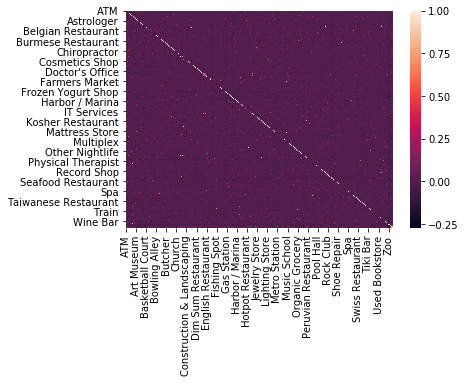

In [114]:
corr = X.corr()
sns.heatmap(corr)

Features are predominantly uncorrelated

In [115]:
c = X.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [116]:
#c.head()

In [117]:
used_pairs = []
strong_correlations = []
correlation_threshold = 0.7
strong_correlations_df_temp = []
for colname in c.columns:
    if verbose == True:
        print("check for features strongly coorelated with " + colname)
    for i in range(0, len(c)):
        this_correlation = c[colname][i]
        if this_correlation >= correlation_threshold:
            if colname != c.index[i]: #don't act on self correlations
                if verbose == True:
                    print("   " + c.index[i] + " - " + str(this_correlation))
                #before adding the new correlation, check to see if the reverse pair already exists
                #if (c.index[i] not in strong_correlations_df_temp[(strong_correlations_df_temp[0]==colname)][1]):
                
                #if True:#(str(strong_correlations_df_temp[(strong_correlations_df_temp[0]==colname)][1]).find(colname) < 0):
                new_pair = str(colname)+'-'+str(c.index[i])
                if new_pair not in used_pairs:
                    strong_correlations.append((colname,c.index[i],this_correlation))
                    used_pairs.append(str(colname)+'-'+str(c.index[i]))
                    used_pairs.append(str(c.index[i])+'-'+str(colname))
            

Whether or not I do anything about correlated features, they are interesting to look at.<br />
Some of them appear to be negatively correlated even I only show the magnitude of the correlation here.<br />
Some of the correlations look like they are due to small samples, such as the Roller Rink in San Francisco that is perfectly correlated with a Spiritual Center. I've actually skated there.<br />
Some correlations look meaningful, such as the correlation between aquariums and zoos.


In [118]:
#strong_correlations_df_temp=pd.DataFrame(strong_correlations)
#strong_correlations_df_temp.set_index((0,,drop=True,inplace=True)
#(c.index[i] not in strong_correlations_df_temp[(strong_correlations_df_temp[0]==colname)][1])
#colname
#c.index[i]
#this_correlation

In [119]:
strong_correlations_df = pd.DataFrame(strong_correlations)

In [120]:
strong_correlations_df["feature_pair"]=strong_correlations_df[0]+"-"+strong_correlations_df[1]

In [121]:
strong_correlations_df.drop([0,1],axis=1, inplace=True)

In [122]:
strong_correlations_df.rename(columns= {2: "correlaton"}, inplace=True)
strong_correlations_df.sort_values(by="correlaton",ascending=False,inplace=True)
strong_correlations_df.set_index("feature_pair", drop=True)

correlaton
feature_pair                                                  
Field-Memorial Site                                   1.000000
Baseball Stadium-Residential Building (Apartmen...    1.000000
Baseball Stadium-Vineyard                             1.000000
Basketball Stadium-Bridge                             1.000000
Theme Restaurant-Tuscan Restaurant                    1.000000
College Track-Parking                                 1.000000
College Baseball Diamond-College Quad                 1.000000
Planetarium-Zoo                                       1.000000
Residential Building (Apartment / Condo)-Vineyard     1.000000
Circus-Fountain                                       0.984616
Comfort Food Restaurant-Locksmith                     0.983835
Elementary School-Sake Bar                            0.966216
Hunting Supply-North Indian Restaurant                0.929528
Baby Store-Medical Center                             0.898896
Bath House-Cupcake Shop                               0.898471
Aquarium-Planetarium                                  0.875823
Aquarium-Zoo                                          0.875823
Roller Rink-Spiritual Center                          0.874030
Business Service-Ski Area                             0.870086
Bike Rental / Bike Share-Tour Provider                0.870037
Field-Museum                                          0.863179
Memorial Site-Museum                                  0.863179
Train-Winery                                          0.851911
Pier-Street Art                                       0.847999
Platform-State / Provincial Park                      0.831350
Kosher Restaurant-Persian Restaurant                  0.817980
Other Great Outdoors-Track                            0.765312
Piercing Parlor-Stationery Store                      0.761992
Road-Tailor Shop                                      0.758532
Food Stand-Halal Restaurant                           0.749473
Newsstand-Veterinarian                                0.748068
Factory-Kitchen Supply Store                          0.744565
random-total_venues_within_radius                     0.741154
Resort-Roof Deck                                      0.739001
Fishing Spot-Tourist Information Center               0.738599
Comedy Club-Trattoria/Osteria                         0.730622
College Quad-Parking                                  0.729543
College Quad-College Track                            0.729543
College Baseball Diamond-Parking                      0.729543
College Baseball Diamond-College Track                0.729543
Bike Rental / Bike Share-Sports Club                  0.722001
Cruise-Lounge                                         0.717580
Auto Workshop-Financial or Legal Service              0.715598
Church-Hostel                                         0.712526
College Gym-Russian Restaurant                        0.701569

I wanted to see if there were strong correlations in the features, so I could remove some.<br />
With 400 or so features and something like 600 data points, I thought it would be good to remove redundant features.<br />
I found strongly correlated features, but my performance was good.<br /> I learned that Random Forests can be
tolerant of correlated features, so removing them seems uneccesary.

In [123]:
#strong_correlations_df

In [124]:
y_val_df = pd.DataFrame(y_val)
y_val_df.columns
y_val_df['isStarbucks'].value_counts()


0    399
1     21
Name: isStarbucks, dtype: int64

In [125]:
RF_all_features_1 = RF("RF_all_features_1", X_train, y_train, X_test, y_test, X_val, y_val)
RF_all_features_1.fit()
RF_all_features_1.get_and_print_results()
RF_all_features_1.feature_importance_df

Random Forest - RF_all_features_1 created
477
-----RF_all_features_1-----
RF_all_features_1 Train accuracy = 0.8736111111111111
RF_all_features_1 Train ROC AUC = 0.9576513801112732
RF_all_features_1 Test accuracy = 0.8222222222222222
RF_all_features_1 Test ROC AUC = 0.9060029644268774
RF_all_features_1 Validation accuracy = 0.8767155985201098
RF_all_features_1 Validation ROC AUC = 0.8767155985201098

RF_all_features_1 Average of Test and Validation accuracy: 0.849468910371166
RF_all_features_1 Average of Test and Validation ROC AUC score: 0.8913592814734936
RF_all_features_1 Num Features: 477


Feature Importance
Feature                                       
restaurant                            0.079069
Sandwich Place                        0.076516
Fast Food Restaurant                  0.060849
rssj                                  0.057997
Mexican Restaurant                    0.050289
Pizza Place                           0.042875
Bank                                  0.032269
Shipping Store                        0.028450
Salon / Barbershop                    0.025036
Grocery Store                         0.021186
Pharmacy                              0.017605
total_venues_within_radius            0.017183
Mobile Phone Shop                     0.015896
American Restaurant                   0.015105
Coffee Shop                           0.012809
Chinese Restaurant                    0.012443
Burger Joint                          0.011715
Park                                  0.011319
Juice Bar                             0.009590
Ice Cream Shop                        0.009483
Shopping Mall                         0.009365
Mediterranean Restaurant              0.008829
Trail                                 0.008337
Playground                            0.008072
Restaurant                            0.008059
Hotel                                 0.007850
Supermarket                           0.007817
Bus Station                           0.007744
ATM                                   0.007710
Diner                                 0.007653
...                                        ...
Roof Deck                             0.000000
Piercing Parlor                       0.000000
Pie Shop                              0.000000
Nature Preserve                       0.000000
Outlet Store                          0.000000
Newsstand                             0.000000
Golf Course                           0.000000
Nightlife Spot                        0.000000
Cable Car                             0.000000
Nudist Beach                          0.000000
Office                                0.000000
Gluten-free Restaurant                0.000000
Other Great Outdoors                  0.000000
Other Nightlife                       0.000000
College Gym                           0.000000
German Restaurant                     0.000000
Paintball Field                       0.000000
Photography Studio                    0.000000
Pakistani Restaurant                  0.000000
General Entertainment                 0.000000
Arepa Restaurant                      0.000000
Parking                               0.000000
Gay Bar                               0.000000
Pedestrian Plaza                      0.000000
Perfume Shop                          0.000000
Persian Restaurant                    0.000000
College Track                         0.000000
Comedy Club                           0.000000
Auto Workshop                         0.000000
Racetrack                             0.000000

[477 rows x 1 columns]

If the test accuracy is a lot lower than the train accuracy, it could be a sign of overfitting

ROC Area Under Curve is a good way of measuring how well the binary classifier separates the two classes, even if the classes are unbalanced

In [126]:
RF_all_features_1.rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [127]:
estimator =  RF_all_features_1.get_estimator(0)

In [128]:
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=209652396, splitter='best')

In [129]:
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ('near-Starbucks','not-near'),
                rounded = True, proportion = True, 
                precision = 2, filled = True)

Display a tree<br />
Note: this is only one tree <br />
Random Forest takes a vote from many trees <br />
It is possible however, to use only one tree (with some loss of accuracy),<br />
and interpret how the classifier is working

In [130]:
# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
Image(filename = 'tree.png')

In [131]:
#eliminate strongly correlated features (although this may not matter so much for a Random Forest)
strong_correlations_temp_df = pd.DataFrame(strong_correlations)

In [132]:
for sc in strong_correlations_temp_df[0]:
    # make an exception for number_of_venues_within_radius - don't want to eliminate this one
    if sc != 'number_of_venues_within_radius':
        try:
            X_train.drop(columns=[sc], inplace=True)
        except:
            pass

        try:
            X_test.drop(columns=[sc], inplace=True)
        except:
            pass
        try:
            X_val.drop(columns=[sc], inplace=True)
        except:
            pass

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [133]:
RF_2 = RF("Random Forest #2", X_train, y_train, X_test, y_test, X_val, y_val)
RF_2.fit()
RF_2.get_and_print_results()
RF_2.feature_importance_df

Random Forest - Random Forest #2 created
439
-----Random Forest #2-----
Random Forest #2 Train accuracy = 0.8777777777777778
Random Forest #2 Train ROC AUC = 0.9557299503823568
Random Forest #2 Test accuracy = 0.8
Random Forest #2 Test ROC AUC = 0.8909337944664032
Random Forest #2 Validation accuracy = 0.8759398496240601
Random Forest #2 Validation ROC AUC = 0.8759398496240601

Random Forest #2 Average of Test and Validation accuracy: 0.83796992481203
Random Forest #2 Average of Test and Validation ROC AUC score: 0.8834368220452317
Random Forest #2 Num Features: 439


Feature Importance
Feature                                       
Sandwich Place                        0.094320
restaurant                            0.077678
rssj                                  0.052858
Mexican Restaurant                    0.042598
Pizza Place                           0.037780
Fast Food Restaurant                  0.036993
Pharmacy                              0.036048
Bank                                  0.029981
total_venues_within_radius            0.025531
Burger Joint                          0.024265
Mobile Phone Shop                     0.020881
Chinese Restaurant                    0.019242
Grocery Store                         0.017021
Juice Bar                             0.015555
American Restaurant                   0.014977
Park                                  0.014668
Salon / Barbershop                    0.014443
Playground                            0.013782
Shipping Store                        0.013664
Asian Restaurant                      0.013496
Ice Cream Shop                        0.013121
Video Store                           0.011574
ATM                                   0.010982
Coffee Shop                           0.010591
Trail                                 0.009730
Café                                  0.009207
Discount Store                        0.008720
Hotel                                 0.008106
no venue                              0.007777
Restaurant                            0.007137
...                                        ...
Golf Course                           0.000000
Afghan Restaurant                     0.000000
Fountain                              0.000000
Shop & Service                        0.000000
Fondue Restaurant                     0.000000
Fish Market                           0.000000
Skate Park                            0.000000
Multiplex                             0.000000
Sake Bar                              0.000000
Russian Restaurant                    0.000000
Hill                                  0.000000
Roof Deck                             0.000000
Irish Pub                             0.000000
Pool                                  0.000000
Indoor Play Area                      0.000000
Indonesian Restaurant                 0.000000
Portuguese Restaurant                 0.000000
Print Shop                            0.000000
Indie Theater                         0.000000
Indie Movie Theater                   0.000000
RV Park                               0.000000
Racetrack                             0.000000
IT Services                           0.000000
Hungarian Restaurant                  0.000000
Recreation Center                     0.000000
Hunan Restaurant                      0.000000
Hotpot Restaurant                     0.000000
Hotel Pool                            0.000000
Hostel                                0.000000
Lake                                  0.000000

[439 rows x 1 columns]

Can we do better using recursive feature elimination?

In [134]:
rf_limited_features = RandomForestClassifier(n_estimators=100, max_depth=MAX_DEPTH, random_state=0)  
if quick == True:
    rfecv = RFECV(estimator=rf_limited_features, step=19, cv=2, scoring='roc_auc', verbose=2) 
else:
    rfecv = RFECV(estimator=rf_limited_features, step=1, cv=2, scoring='roc_auc', verbose=2)     
selector=rfecv.fit(X_train, y_train)

Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
F

In [135]:
reduced_features_preds = selector.predict(X_train)

In [136]:
selector.score(X_train,y_train)

0.8888888888888888

In [137]:
selector_score = selector.score(X_test,y_test)
selector_score

0.8166666666666667

In [138]:
selector.n_features_

317

In [139]:
selector

RFECV(cv=2,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
   verbose=2)

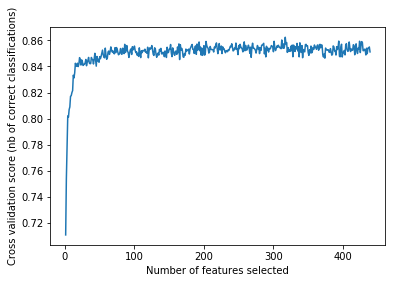

In [140]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Selector picked 140 features, but that looks like a noisy spike<br />
Half that (~70) looks like it would do fine, but there is no real loss by keeping extra features<br />
Random Forest model does fairly well with extra features

Give svm a try

In [141]:
SVM_rbf = SVM("SVM (with rbf kernel)",'rbf', X_train, y_train, X_test, y_test, X_val, y_val)
SVM_rbf.fit()
SVM_rbf.predict(X_test)
SVM_rbf.print_scores()

Support Vector Machine - SVM (with rbf kernel) created
-----SVM (with rbf kernel)-----
SVM (with rbf kernel) Train accuracy = 0.8
SVM (with rbf kernel) Train ROC AUC = 0.887542344761596
SVM (with rbf kernel) Test accuracy = 0.7722222222222223
SVM (with rbf kernel) Test ROC AUC = 0.8782114624505929
SVM (with rbf kernel) Validation accuracy = 0.95
SVM (with rbf kernel) Validation ROC AUC = 0.8566654732068266

SVM (with rbf kernel) Average of Test and Validation accuracy: 0.8611111111111112
SVM (with rbf kernel) Average of Test and Validation ROC AUC score: 0.8674384678287097


439


In [142]:
SVM_linear = SVM("SVM (with linear kernel)",'linear', X_train, y_train, X_test, y_test, X_val, y_val)
SVM_linear.fit()
SVM_linear.predict(X_test)
SVM_linear.print_scores()

Support Vector Machine - SVM (with linear kernel) created
-----SVM (with linear kernel)-----
SVM (with linear kernel) Train accuracy = 0.7819444444444444
SVM (with linear kernel) Train ROC AUC = 0.855213710828684
SVM (with linear kernel) Test accuracy = 0.7555555555555555
SVM (with linear kernel) Test ROC AUC = 0.8302865612648221
SVM (with linear kernel) Validation accuracy = 0.7285714285714285
SVM (with linear kernel) Validation ROC AUC = 0.8403150733977802

SVM (with linear kernel) Average of Test and Validation accuracy: 0.7420634920634921
SVM (with linear kernel) Average of Test and Validation ROC AUC score: 0.8353008173313012


439


In [143]:
SVM_poly = SVM("SVM (with poly kernel)",'poly', X_train, y_train, X_test, y_test, X_val, y_val)
SVM_poly.fit()
SVM_poly.predict(X_test)
SVM_poly.print_scores()

Support Vector Machine - SVM (with poly kernel) created
-----SVM (with poly kernel)-----
SVM (with poly kernel) Train accuracy = 0.9180555555555555
SVM (with poly kernel) Train ROC AUC = 0.9545261630823128
SVM (with poly kernel) Test accuracy = 0.8055555555555556
SVM (with poly kernel) Test ROC AUC = 0.816699604743083
SVM (with poly kernel) Validation accuracy = 0.9214285714285714
SVM (with poly kernel) Validation ROC AUC = 0.6253729562000238

SVM (with poly kernel) Average of Test and Validation accuracy: 0.8634920634920635
SVM (with poly kernel) Average of Test and Validation ROC AUC score: 0.7210362804715533


439


In [144]:
SVM_sigmoid = SVM("SVM (with sigmoid kernel)",'sigmoid', X_train, y_train, X_test, y_test, X_val, y_val)
SVM_sigmoid.fit()
SVM_sigmoid.predict(X_test)
SVM_sigmoid.print_scores()

Support Vector Machine - SVM (with sigmoid kernel) created
-----SVM (with sigmoid kernel)-----
SVM (with sigmoid kernel) Train accuracy = 0.5041666666666667
SVM (with sigmoid kernel) Train ROC AUC = 0.3423385883278932
SVM (with sigmoid kernel) Test accuracy = 0.4888888888888889
SVM (with sigmoid kernel) Test ROC AUC = 0.3354743083003952
SVM (with sigmoid kernel) Validation accuracy = 0.8523809523809524
SVM (with sigmoid kernel) Validation ROC AUC = 0.1904165174841867

SVM (with sigmoid kernel) Average of Test and Validation accuracy: 0.6706349206349206
SVM (with sigmoid kernel) Average of Test and Validation ROC AUC score: 0.26294541289229095


439


Looks like RandomForest and SVM with an rbf kernel do well<br />
Maybe we should try those with smaller feature sets

In [145]:
#tried dropping my added feature but lets keep it
#X_train.drop(['number_of_venues_within_radius'], axis=1)
#X_test.drop(['number_of_venues_within_radius'], axis=1)

In [146]:
#Instead let's try dropping some highly correlated features

In [147]:
map_testing_data = folium.Map(location=[ulat, ulon], zoom_start=12)

In [148]:
test_answer_key = onehot
test_answer_key.tail()

point_lat   point_lon  isStarbucks  ATM  Acai House  Accessories Store  \
17892   37.92886 -122.320997            1    0           0                  0   
17893   37.92886 -122.320997            1    0           0                  0   
17894   37.92886 -122.320997            1    0           0                  0   
17895   37.92886 -122.320997            1    0           0                  0   
17896   37.92886 -122.320997            1    0           0                  0   

       Acupuncturist  Adult Boutique  Afghan Restaurant  African Restaurant  \
17892              0               0                  0                   0   
17893              0               0                  0                   0   
17894              0               0                  0                   0   
17895              0               0                  0                   0   
17896              0               0                  0                   0   

       ...  Wings Joint  Women's Store  Yoga Studio  Zoo  no venue  \
17892  ...            0              0            0    0         0   
17893  ...            0              0            0    0         0   
17894  ...            0              0            0    0         0   
17895  ...            0              0            0    0         0   
17896  ...            0              0            0    0         0   

       point_name  number_of_venues_within_radius  ones  restaurant  rssj  
17892  point00899                             NaN     1           0     0  
17893  point00899                             NaN     1           0     0  
17894  point00899                             NaN     1           1     2  
17895  point00899                             NaN     1           1     2  
17896  point00899                             NaN     1           1     2  

[5 rows x 478 columns]

In [149]:
test_answer_key_unique = pd.DataFrame(test_answer_key.groupby(['point_name']))

In [150]:
test_answer_key_unique = test_answer_key[['point_name','point_lat','point_lon','isStarbucks']]

In [151]:
if slow_maps == True:
    last_point_name = ''
    # add markers for my predicted classes to map
    #for lat, lng in zip(validation_venues['Neighborhood Latitude'],validation_venues['Neighborhood Longitude']):
    ##for lat, lng in zip(validation_points[0],validation_points[1]):
    count = 0
    for point_name, lat, lng, isSB in zip(test_answer_key['point_name'],test_answer_key['point_lat'],test_answer_key['point_lon'],test_answer_key['isStarbucks']):    

        if point_name != last_point_name:
        
            if isSB > 0 :
                color_str = 'green'
                #print(color_str)
            else:
                color_str = 'blue'
                #print(color_str)
  
            if count < 20000:
                folium.CircleMarker(
                    [lat, lng],
                    radius=5,
                    color=color_str,        
                    fill=False,
                    fill_color='#3186cc',
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_testing_data)  
            count = count + 1
        #print(point_name)     
            sb_test_locs = getStarbucksLocations(lat, lng, limit=200)
            sb_test_locs_df = pd.DataFrame(sb_test_locs)
            sb_test_locs_df.head()

            if len(sb_test_locs) > 0: 
                for sblat, sblng in zip(sb_test_locs_df[0],sb_test_locs_df[1]):                  
                    folium.CircleMarker(
                        [sblat, sblng],
                        radius=5,
                        color='red',        
                        fill=False,
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_testing_data)  
            count = count + 1
        last_point_name = point_name

In [152]:
if slow_maps == True:
    map_testing_data_legend_html =   '''
                    <div style="position: fixed; 
                                bottom: 50px; left: 500px; width: 168px; height: 130px; 
                                border:2px solid grey; z-index:9999; font-size:14px;
                                #background: white;
                                ">
                                  <div style="font-size:10px;"><br />&nbsp; Class 1 is predicted to be within <br /> 
                                  &nbsp; 300m of a Starbucks location <br />
                                  &nbsp;<br />
                             
                                  </div>
                         
                                  &nbsp;&nbsp;&nbsp; predicted class 0: &nbsp; <i class="fa fa-circle-o style="color:blue"></i><br>
                                  &nbsp;&nbsp;&nbsp; predicted class 1: &nbsp; <i class="fa fa-circle-o style="color:green"></i><br>                              
                                  &nbsp;&nbsp;&nbsp; true class 1: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <i class="fa fa-circle-o" style="color:red">
                                  </i>
                    </div>
                    ''' 
    map_testing_data.get_root().html.add_child(folium.Element(map_testing_data_legend_html))   

In [153]:
map_testing_data

In [154]:
if slow_maps == True:
    validate_center_lat = validate_llat+(validate_ulat-validate_llat)/2
    validate_center_lon = validate_llon+(validate_ulon-validate_llon)/2
    validation_map = folium.Map(location=[validate_center_lat, validate_center_lon], zoom_start=12)

In [157]:
if slow_maps == True:
    # add markers for known Starbucks to map
    for lat, lng in zip(sb_locations_df[0],sb_locations_df[1]): 
    #for lat, lng in zip(sb_locations_df['0'],sb_locations_df['1']): 
        color_str = 'red'

        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=color_str,        
            fill=False,
            #fill_color='#3186cc',
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(validation_map)  

In [158]:
if slow_maps == True:
    map_validation_data_legend_html =   '''
                    <div style="position: fixed; 
                                bottom: 50px; left: 30px; width: 168px; height: 130px; 
                                border:2px solid grey; z-index:9999; font-size:14px;
                                #background: white;
                                ">
                                  <div style="font-size:10px;"><br />&nbsp; Class 1 is predicted<br /> 
                                  &nbsp; to be within 300m of <br />
                                  &nbsp; aStarbucks location<br />
                             
                                  </div>
                              
                                  &nbsp;&nbsp;&nbsp; predicted class 0: &nbsp; <i class="fa fa-circle-o style="color:blue"></i><br>
                                  &nbsp;&nbsp;&nbsp; predicted class 1: &nbsp; <i class="fa fa-circle-o style="color:green"></i><br>                              
                                  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; true class 1: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <i class="fa fa-circle-o" style="color:red">
                                  </i>
                    </div>
                    ''' 
    validation_map.get_root().html.add_child(folium.Element(map_validation_data_legend_html))

In [159]:
if slow_maps == True:
    # add markers for my predicted classes to map
    #for lat, lng in zip(validation_venues['Neighborhood Latitude'],validation_venues['Neighborhood Longitude']):
    ##for lat, lng in zip(validation_points[0],validation_points[1]):
    for lat, lng, isSB in zip(validation_answer_key['point_lat'],validation_answer_key['point_lon'],validation_answer_key['isStarbucks']):    

        if isSB > 0 :
            color_str = 'green'
        else:
            color_str = 'blue'

        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=color_str,        
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(validation_map)  
    


In [160]:
if slow_maps == True:
    validation_map

In [161]:
validation_map

In [162]:
##### end validate #####

In [163]:
feature_importance_df = RF_2.feature_importance_df
#feature_importance_df = RF_all_features_1.feature_importance_df

In [164]:
#Save original matrices before you start cutting them up (just for safe keeping in case needed again)
X_train_orig = X_train.copy(deep=True)
y_train_orig = y_train.copy(deep=True)
X_test_orig = X_test.copy(deep=True)
y_test_orig = y_test.copy(deep=True)
X_val_orig = X_val.copy(deep=True)
y_val_orig = y_val.copy(deep=True)
feature_importance_df_orig = feature_importance_df.copy(deep=True)

In [165]:
verbose = False

def drop_features_below_cutoff(cutoff, feature_importance_df, this_df):
    count = 0
    num_to_do = feature_importance_df.size - cutoff
    for feature in feature_importance_df[cutoff:feature_importance_df.size].index: 
        if verbose == True:
            print("removing feature: " + str(feature) + " with importance = " + str(feature_importance_df.loc[feature]['Feature Importance']))
        try:
            this_df.drop(columns=[feature], inplace=True)
        except:
            if verbose == True:
                print("EXCEPTION - removing feature: " + str(feature) + " with importance = " + str(feature_importance_df.loc[feature]['Feature Importance']))
        
        
        # progress indicator for the impatient among us
        if(count%20 == 0):
            pass
           # print("\r{0}".format(round((float(count)/num_to_do*100),2)+"% done"), end='')
           # print("\r{0}".format(round((float(count/num_to_do*100)),2)+"% done"), end='')            
            
        count = count + 1            
    return(this_df)

In [166]:
verbose = False
def drop_features_on_all_sets(cutoff, feature_importance_df, X_train, X_test, X_val):
    X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
    X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)
    X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
    return(X_train, X_test, X_val)

In [167]:
len(X_train.columns)


439

In [176]:
# drop features with importance below cutoff
cutoff = selector.n_features_
X_train, X_test, X_val  = drop_features_on_all_sets(cutoff, feature_importance_df, X_train, X_test, X_val)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [177]:
RF_3 = RF("Random Forest #3", X_train, y_train, X_test, y_test, X_val, y_val)
RF_3.fit()
RF_3.get_and_print_results()
RF_3.feature_importance_df

Random Forest - Random Forest #3 created
45
-----Random Forest #3-----
Random Forest #3 Train accuracy = 0.9069444444444444
Random Forest #3 Train ROC AUC = 0.9691876750700279
Random Forest #3 Test accuracy = 0.8
Random Forest #3 Test ROC AUC = 0.8982213438735177
Random Forest #3 Validation accuracy = 0.8607232366630863
Random Forest #3 Validation ROC AUC = 0.8607232366630863

Random Forest #3 Average of Test and Validation accuracy: 0.8303616183315432
Random Forest #3 Average of Test and Validation ROC AUC score: 0.879472290268302
Random Forest #3 Num Features: 45


Feature Importance
Feature                                       
Sandwich Place                        0.122552
rssj                                  0.093424
restaurant                            0.093423
Fast Food Restaurant                  0.084212
Bank                                  0.043177
Pizza Place                           0.041443
Pharmacy                              0.039270
Mexican Restaurant                    0.037014
total_venues_within_radius            0.032530
Mobile Phone Shop                     0.030104
Grocery Store                         0.029306
Burger Joint                          0.021892
Shipping Store                        0.021303
Park                                  0.021165
Coffee Shop                           0.021094
Café                                  0.020087
American Restaurant                   0.017641
Chinese Restaurant                    0.015698
Salon / Barbershop                    0.014963
Juice Bar                             0.013020
New American Restaurant               0.012086
Bakery                                0.011822
Ice Cream Shop                        0.011488
Mediterranean Restaurant              0.009946
Cosmetics Shop                        0.009636
Playground                            0.009513
Hotel                                 0.009065
Asian Restaurant                      0.008953
Gas Station                           0.008874
Video Store                           0.008857
Shopping Mall                         0.008814
Department Store                      0.008427
Sushi Restaurant                      0.007591
ATM                                   0.007099
Trail                                 0.006619
Supermarket                           0.006518
Kids Store                            0.006264
Restaurant                            0.006243
Discount Store                        0.005889
Furniture / Home Store                0.005799
Diner                                 0.005650
Donut Shop                            0.005605
Video Game Store                      0.003067
Supplement Shop                       0.002781
no venue                              0.000073

In [171]:
cutoff = 50
# drop features with importance below cutoff
X_train, X_test, X_val  = drop_features_on_all_sets(cutoff, feature_importance_df, X_train, X_test, X_val)

#X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
#X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)
#X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val)


/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [179]:
RF_4 = RF("Random Forest #4", X_train, y_train, X_test, y_test, X_val, y_val)
RF_4.fit()
RF_4.get_and_print_results()
RF_4.feature_importance_df

Random Forest - Random Forest #4 created
45
-----Random Forest #4-----
Random Forest #4 Train accuracy = 0.9069444444444444
Random Forest #4 Train ROC AUC = 0.9691876750700279
Random Forest #4 Test accuracy = 0.8
Random Forest #4 Test ROC AUC = 0.8982213438735177
Random Forest #4 Validation accuracy = 0.8607232366630863
Random Forest #4 Validation ROC AUC = 0.8607232366630863

Random Forest #4 Average of Test and Validation accuracy: 0.8303616183315432
Random Forest #4 Average of Test and Validation ROC AUC score: 0.879472290268302
Random Forest #4 Num Features: 45


Feature Importance
Feature                                       
Sandwich Place                        0.122552
rssj                                  0.093424
restaurant                            0.093423
Fast Food Restaurant                  0.084212
Bank                                  0.043177
Pizza Place                           0.041443
Pharmacy                              0.039270
Mexican Restaurant                    0.037014
total_venues_within_radius            0.032530
Mobile Phone Shop                     0.030104
Grocery Store                         0.029306
Burger Joint                          0.021892
Shipping Store                        0.021303
Park                                  0.021165
Coffee Shop                           0.021094
Café                                  0.020087
American Restaurant                   0.017641
Chinese Restaurant                    0.015698
Salon / Barbershop                    0.014963
Juice Bar                             0.013020
New American Restaurant               0.012086
Bakery                                0.011822
Ice Cream Shop                        0.011488
Mediterranean Restaurant              0.009946
Cosmetics Shop                        0.009636
Playground                            0.009513
Hotel                                 0.009065
Asian Restaurant                      0.008953
Gas Station                           0.008874
Video Store                           0.008857
Shopping Mall                         0.008814
Department Store                      0.008427
Sushi Restaurant                      0.007591
ATM                                   0.007099
Trail                                 0.006619
Supermarket                           0.006518
Kids Store                            0.006264
Restaurant                            0.006243
Discount Store                        0.005889
Furniture / Home Store                0.005799
Diner                                 0.005650
Donut Shop                            0.005605
Video Game Store                      0.003067
Supplement Shop                       0.002781
no venue                              0.000073

In [173]:
SVM_rbf_2 = SVM("SVM 2 (with rbf kernel)",'rbf', X_train, y_train, X_test, y_test, X_val, y_val)
SVM_rbf_2.fit()
SVM_rbf_2.predict(X_test)
SVM_rbf_2.print_scores()

Support Vector Machine - SVM 2 (with rbf kernel) created
-----SVM 2 (with rbf kernel)-----
SVM 2 (with rbf kernel) Train accuracy = 0.7791666666666667
SVM 2 (with rbf kernel) Train ROC AUC = 0.8654304697085445
SVM 2 (with rbf kernel) Test accuracy = 0.7555555555555555
SVM 2 (with rbf kernel) Test ROC AUC = 0.866600790513834
SVM 2 (with rbf kernel) Validation accuracy = 0.8857142857142857
SVM 2 (with rbf kernel) Validation ROC AUC = 0.817579663444325

SVM 2 (with rbf kernel) Average of Test and Validation accuracy: 0.8206349206349206
SVM 2 (with rbf kernel) Average of Test and Validation ROC AUC score: 0.8420902269790795


50


In [174]:
rf_limited_features = RandomForestClassifier(n_estimators=100, max_depth=MAX_DEPTH, random_state=0)  
rfecv = RFECV(estimator=rf_limited_features, step=1, cv=2, scoring='roc_auc', verbose=2) 
selector=rfecv.fit(X_train, y_train)

Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 fe

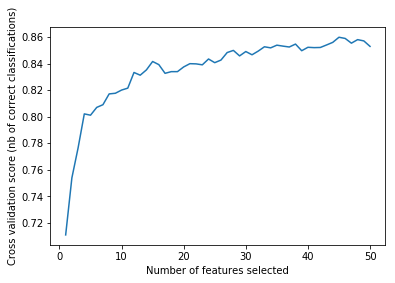

In [175]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


Now let's set the cutoff to the feature importance level where the selector plot first hits<br />
the high plateau

In [180]:
cutoff = 20
# drop features with importance below cutoff
X_train, X_test, X_val  = drop_features_on_all_sets(cutoff, feature_importance_df, X_train, X_test, X_val)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [181]:
# drop features with importance below cutoff
#cutoff = 20
#X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
#X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)   
#X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val)   

In [182]:
RF_5 = RF("Random Forest #5", X_train, y_train, X_test, y_test, X_val, y_val)
RF_5.fit()
RF_5.get_and_print_results()
RF_5.feature_importance_df

Random Forest - Random Forest #5 created
20
-----Random Forest #5-----
Random Forest #5 Train accuracy = 0.8875
Random Forest #5 Train ROC AUC = 0.9668109668109668
Random Forest #5 Test accuracy = 0.7888888888888889
Random Forest #5 Test ROC AUC = 0.8789525691699605
Random Forest #5 Validation accuracy = 0.8579186060389068
Random Forest #5 Validation ROC AUC = 0.8579186060389068

Random Forest #5 Average of Test and Validation accuracy: 0.8234037474638978
Random Forest #5 Average of Test and Validation ROC AUC score: 0.8684355876044336
Random Forest #5 Num Features: 20


Feature Importance
Feature                                       
Sandwich Place                        0.136150
Fast Food Restaurant                  0.135394
rssj                                  0.130089
restaurant                            0.116599
Mexican Restaurant                    0.062032
Pizza Place                           0.052394
Bank                                  0.048027
Pharmacy                              0.042318
total_venues_within_radius            0.037887
Shipping Store                        0.031649
Park                                  0.028509
Mobile Phone Shop                     0.026311
Grocery Store                         0.025034
American Restaurant                   0.022934
Salon / Barbershop                    0.022591
Burger Joint                          0.022156
Chinese Restaurant                    0.020190
Playground                            0.015307
Juice Bar                             0.012935
Asian Restaurant                      0.011493

In [183]:
X_train.columns

Index(['American Restaurant', 'Asian Restaurant', 'Bank', 'Burger Joint',
       'Chinese Restaurant', 'Fast Food Restaurant', 'Grocery Store',
       'Juice Bar', 'Mexican Restaurant', 'Mobile Phone Shop', 'Park',
       'Pharmacy', 'Pizza Place', 'Playground', 'Salon / Barbershop',
       'Sandwich Place', 'Shipping Store', 'restaurant', 'rssj',
       'total_venues_within_radius'],
      dtype='object')

In [184]:
rf_limited_features = RandomForestClassifier(n_estimators=100, max_depth=MAX_DEPTH, random_state=0)  
rfecv = RFECV(estimator=rf_limited_features, step=1, cv=2, scoring='roc_auc', verbose=2) 
selector=rfecv.fit(X_train, y_train)

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


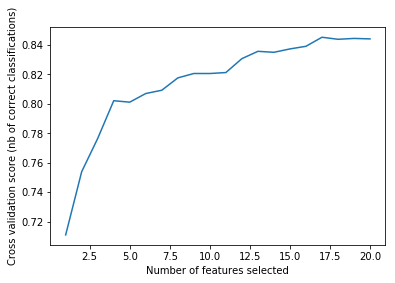

In [185]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [186]:
feature_importance_df

Feature Importance
Feature                                       
Sandwich Place                        0.094320
restaurant                            0.077678
rssj                                  0.052858
Mexican Restaurant                    0.042598
Pizza Place                           0.037780
Fast Food Restaurant                  0.036993
Pharmacy                              0.036048
Bank                                  0.029981
total_venues_within_radius            0.025531
Burger Joint                          0.024265
Mobile Phone Shop                     0.020881
Chinese Restaurant                    0.019242
Grocery Store                         0.017021
Juice Bar                             0.015555
American Restaurant                   0.014977
Park                                  0.014668
Salon / Barbershop                    0.014443
Playground                            0.013782
Shipping Store                        0.013664
Asian Restaurant                      0.013496
Ice Cream Shop                        0.013121
Video Store                           0.011574
ATM                                   0.010982
Coffee Shop                           0.010591
Trail                                 0.009730
Café                                  0.009207
Discount Store                        0.008720
Hotel                                 0.008106
no venue                              0.007777
Restaurant                            0.007137
...                                        ...
Golf Course                           0.000000
Afghan Restaurant                     0.000000
Fountain                              0.000000
Shop & Service                        0.000000
Fondue Restaurant                     0.000000
Fish Market                           0.000000
Skate Park                            0.000000
Multiplex                             0.000000
Sake Bar                              0.000000
Russian Restaurant                    0.000000
Hill                                  0.000000
Roof Deck                             0.000000
Irish Pub                             0.000000
Pool                                  0.000000
Indoor Play Area                      0.000000
Indonesian Restaurant                 0.000000
Portuguese Restaurant                 0.000000
Print Shop                            0.000000
Indie Theater                         0.000000
Indie Movie Theater                   0.000000
RV Park                               0.000000
Racetrack                             0.000000
IT Services                           0.000000
Hungarian Restaurant                  0.000000
Recreation Center                     0.000000
Hunan Restaurant                      0.000000
Hotpot Restaurant                     0.000000
Hotel Pool                            0.000000
Hostel                                0.000000
Lake                                  0.000000

[439 rows x 1 columns]

In [187]:
# Get the position of the random feature in the sorted feature_importances_df
random_position = len(feature_importance_df) # default to max
for i in range(0, len(feature_importance_df)):
    #print(feature_importance_df.iloc[i].name)
    if feature_importance_df.iloc[i].name == 'random':
        random_position = i
        break

Now let's set the cutoff to the feature importance level of the random feature

In [188]:
# drop features with importance below cutoff
cutoff = random_position
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 

In [189]:
RF_6 = RF("Random Forest #6", X_train, y_train, X_test, y_test, X_val, y_val)
RF_6.fit()
RF_6.get_and_print_results()
RF_6.feature_importance_df

Random Forest - Random Forest #6 created
20
-----Random Forest #6-----
Random Forest #6 Train accuracy = 0.8875
Random Forest #6 Train ROC AUC = 0.9668109668109668
Random Forest #6 Test accuracy = 0.7888888888888889
Random Forest #6 Test ROC AUC = 0.8789525691699605
Random Forest #6 Validation accuracy = 0.8579186060389068
Random Forest #6 Validation ROC AUC = 0.8579186060389068

Random Forest #6 Average of Test and Validation accuracy: 0.8234037474638978
Random Forest #6 Average of Test and Validation ROC AUC score: 0.8684355876044336
Random Forest #6 Num Features: 20


Feature Importance
Feature                                       
Sandwich Place                        0.136150
Fast Food Restaurant                  0.135394
rssj                                  0.130089
restaurant                            0.116599
Mexican Restaurant                    0.062032
Pizza Place                           0.052394
Bank                                  0.048027
Pharmacy                              0.042318
total_venues_within_radius            0.037887
Shipping Store                        0.031649
Park                                  0.028509
Mobile Phone Shop                     0.026311
Grocery Store                         0.025034
American Restaurant                   0.022934
Salon / Barbershop                    0.022591
Burger Joint                          0.022156
Chinese Restaurant                    0.020190
Playground                            0.015307
Juice Bar                             0.012935
Asian Restaurant                      0.011493

In [190]:
cutoff = 15
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_7 = RF("Random Forest #7", X_train, y_train, X_test, y_test, X_val, y_val)
RF_7.fit()
RF_7.get_and_print_results()
RF_7.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #7 created
15
-----Random Forest #7-----
Random Forest #7 Train accuracy = 0.8777777777777778
Random Forest #7 Train ROC AUC = 0.9655956046330378
Random Forest #7 Test accuracy = 0.7944444444444444
Random Forest #7 Test ROC AUC = 0.8882164031620554
Random Forest #7 Validation accuracy = 0.8532641126626089
Random Forest #7 Validation ROC AUC = 0.8532641126626089

Random Forest #7 Average of Test and Validation accuracy: 0.8238542785535267
Random Forest #7 Average of Test and Validation ROC AUC score: 0.8707402579123322
Random Forest #7 Num Features: 15


Feature Importance
Feature                                       
Sandwich Place                        0.160662
Fast Food Restaurant                  0.130570
restaurant                            0.129850
rssj                                  0.097792
Pizza Place                           0.072348
Mexican Restaurant                    0.068152
Pharmacy                              0.056909
Bank                                  0.056025
total_venues_within_radius            0.045751
Mobile Phone Shop                     0.037612
Burger Joint                          0.037012
Grocery Store                         0.034459
American Restaurant                   0.029604
Chinese Restaurant                    0.025884
Juice Bar                             0.017368

In [191]:
cutoff = 12
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_8 = RF("Random Forest #8", X_train, y_train, X_test, y_test, X_val, y_val)
RF_8.fit()
RF_8.get_and_print_results()
RF_8.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #8 created
12
-----Random Forest #8-----
Random Forest #8 Train accuracy = 0.8652777777777778
Random Forest #8 Train ROC AUC = 0.9576976796228134
Random Forest #8 Test accuracy = 0.8
Random Forest #8 Test ROC AUC = 0.8775938735177866
Random Forest #8 Validation accuracy = 0.8480128893662728
Random Forest #8 Validation ROC AUC = 0.8480128893662728

Random Forest #8 Average of Test and Validation accuracy: 0.8240064446831364
Random Forest #8 Average of Test and Validation ROC AUC score: 0.8628033814420297
Random Forest #8 Num Features: 12


Feature Importance
Feature                                       
restaurant                            0.181326
Sandwich Place                        0.164716
rssj                                  0.136508
Fast Food Restaurant                  0.126677
Mexican Restaurant                    0.065347
Bank                                  0.061996
Pizza Place                           0.061432
Pharmacy                              0.053067
total_venues_within_radius            0.051393
Mobile Phone Shop                     0.039197
Burger Joint                          0.033176
Chinese Restaurant                    0.025165

In [192]:
cutoff = 10
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_9 = RF("Random Forest #9", X_train, y_train, X_test, y_test, X_val, y_val)
RF_9.fit()
RF_9.get_and_print_results()
RF_9.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #9 created
10
-----Random Forest #9-----
Random Forest #9 Train accuracy = 0.8708333333333333
Random Forest #9 Train ROC AUC = 0.9584384718074557
Random Forest #9 Test accuracy = 0.8
Random Forest #9 Test ROC AUC = 0.879199604743083
Random Forest #9 Validation accuracy = 0.8405537653657954
Random Forest #9 Validation ROC AUC = 0.8405537653657954

Random Forest #9 Average of Test and Validation accuracy: 0.8202768826828977
Random Forest #9 Average of Test and Validation ROC AUC score: 0.8598766850544393
Random Forest #9 Num Features: 10


Feature Importance
Feature                                       
Sandwich Place                        0.195673
restaurant                            0.193558
Fast Food Restaurant                  0.155375
rssj                                  0.117042
Mexican Restaurant                    0.067338
Pizza Place                           0.062969
Bank                                  0.056974
total_venues_within_radius            0.055617
Pharmacy                              0.051815
Burger Joint                          0.043639

In [193]:
cutoff = 8
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_10 = RF("Random Forest #10", X_train, y_train, X_test, y_test, X_val, y_val)
RF_10.fit()
RF_10.get_and_print_results()
RF_10.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #10 created
8
-----Random Forest #10-----
Random Forest #10 Train accuracy = 0.8597222222222223
Random Forest #10 Train ROC AUC = 0.9512080314219353
Random Forest #10 Test accuracy = 0.8
Random Forest #10 Test ROC AUC = 0.883399209486166
Random Forest #10 Validation accuracy = 0.8275450531089629
Random Forest #10 Validation ROC AUC = 0.8275450531089629

Random Forest #10 Average of Test and Validation accuracy: 0.8137725265544815
Random Forest #10 Average of Test and Validation ROC AUC score: 0.8554721312975644
Random Forest #10 Num Features: 8


Feature Importance
Feature                                 
restaurant                      0.195636
Sandwich Place                  0.182272
Fast Food Restaurant            0.160689
rssj                            0.138990
Mexican Restaurant              0.098194
Pizza Place                     0.079465
Bank                            0.074115
Pharmacy                        0.070640

In [194]:
cutoff = 5
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_11 = RF("Random Forest #11", X_train, y_train, X_test, y_test, X_val, y_val)
RF_11.fit()
RF_11.get_and_print_results()
RF_11.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #11 created
5
-----Random Forest #11-----
Random Forest #11 Train accuracy = 0.8430555555555556
Random Forest #11 Train ROC AUC = 0.9188716809037665
Random Forest #11 Test accuracy = 0.7388888888888889
Random Forest #11 Test ROC AUC = 0.8499258893280632
Random Forest #11 Validation accuracy = 0.841985917173887
Random Forest #11 Validation ROC AUC = 0.841985917173887

Random Forest #11 Average of Test and Validation accuracy: 0.790437403031388
Random Forest #11 Average of Test and Validation ROC AUC score: 0.8459559032509751
Random Forest #11 Num Features: 5


Feature Importance
Feature                               
restaurant                    0.308861
Sandwich Place                0.302749
rssj                          0.212731
Pizza Place                   0.089393
Mexican Restaurant            0.086267

In [195]:
cutoff = 4
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_12 = RF("Random Forest #12", X_train, y_train, X_test, y_test, X_val, y_val)
RF_12.fit()
RF_12.get_and_print_results()
RF_12.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #12 created
4
-----Random Forest #12-----
Random Forest #12 Train accuracy = 0.8305555555555556
Random Forest #12 Train ROC AUC = 0.9149400807154817
Random Forest #12 Test accuracy = 0.7555555555555555
Random Forest #12 Test ROC AUC = 0.8423295454545454
Random Forest #12 Validation accuracy = 0.8310060866451844
Random Forest #12 Validation ROC AUC = 0.8310060866451844

Random Forest #12 Average of Test and Validation accuracy: 0.7932808211003699
Random Forest #12 Average of Test and Validation ROC AUC score: 0.8366678160498648
Random Forest #12 Num Features: 4


Feature Importance
Feature                               
restaurant                    0.358890
Sandwich Place                0.304311
rssj                          0.236288
Mexican Restaurant            0.100511

In [196]:
cutoff = 3
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_13 = RF("Random Forest #13", X_train, y_train, X_test, y_test, X_val, y_val)
RF_13.fit()
RF_13.get_and_print_results()
RF_13.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #13 created
3
-----Random Forest #13-----
Random Forest #13 Train accuracy = 0.8333333333333334
Random Forest #13 Train ROC AUC = 0.9016907038297414
Random Forest #13 Test accuracy = 0.7611111111111111
Random Forest #13 Test ROC AUC = 0.8414031620553359
Random Forest #13 Validation accuracy = 0.8455662966941162
Random Forest #13 Validation ROC AUC = 0.8455662966941162

Random Forest #13 Average of Test and Validation accuracy: 0.8033387039026136
Random Forest #13 Average of Test and Validation ROC AUC score: 0.8434847293747261
Random Forest #13 Num Features: 3


Feature Importance
Feature                           
restaurant                0.406669
Sandwich Place            0.311883
rssj                      0.281448

In [197]:
cutoff = 2
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_14 = RF("Random Forest #14", X_train, y_train, X_test, y_test, X_val, y_val)
RF_14.fit()
RF_14.get_and_print_results()
RF_14.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #14 created
2
-----Random Forest #14-----
Random Forest #14 Train accuracy = 0.7722222222222223
Random Forest #14 Train ROC AUC = 0.8893711754674323
Random Forest #14 Test accuracy = 0.7277777777777777
Random Forest #14 Test ROC AUC = 0.8333745059288536
Random Forest #14 Validation accuracy = 0.7778971237617854
Random Forest #14 Validation ROC AUC = 0.7778971237617854

Random Forest #14 Average of Test and Validation accuracy: 0.7528374507697816
Random Forest #14 Average of Test and Validation ROC AUC score: 0.8056358148453195
Random Forest #14 Num Features: 2


Feature Importance
Feature                           
restaurant                0.543696
Sandwich Place            0.456304

In [198]:
cutoff = 1
X_train = drop_features_below_cutoff(cutoff, feature_importance_df, X_train)
X_test = drop_features_below_cutoff(cutoff, feature_importance_df, X_test)    
X_val = drop_features_below_cutoff(cutoff, feature_importance_df, X_val) 
RF_15 = RF("Random Forest #15", X_train, y_train, X_test, y_test, X_val, y_val)
RF_15.fit()
RF_15.get_and_print_results()
RF_15.feature_importance_df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Random Forest - Random Forest #15 created
1
-----Random Forest #15-----
Random Forest #15 Train accuracy = 0.7416666666666667
Random Forest #15 Train ROC AUC = 0.778850383128458
Random Forest #15 Test accuracy = 0.7166666666666667
Random Forest #15 Test ROC AUC = 0.7632781620553358
Random Forest #15 Validation accuracy = 0.7358873373910967
Random Forest #15 Validation ROC AUC = 0.7358873373910967

Random Forest #15 Average of Test and Validation accuracy: 0.7262770020288817
Random Forest #15 Average of Test and Validation ROC AUC score: 0.7495827497232163
Random Forest #15 Num Features: 1


Feature Importance
Feature                           
Sandwich Place                 1.0